## Libraries and file paths

In [1]:
from pathlib import Path
from tab_hero.dataio.tab_format import load_tab
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    homogeneity_score,
    completeness_score,
)
import matplotlib.pyplot as plt

In [2]:
dir_root = Path().cwd().parent
dir_preprocessed_data = dir_root / 'data' / 'processed'

## Source data

View preprocessed tab data

In [3]:
for i, tab_file in enumerate(dir_preprocessed_data.glob('*.tab')):
    print(tab_file)
    
    tab_data = load_tab(tab_file)
    
    print(tab_data)
    
    if i == 10:
        break

e:\Python Projects\tab-hero\data\processed\00025e292bfacc9b.tab
TabData(mel_spectrogram=array([[-2.8632812, -2.8632812, -2.8632812, ..., -2.8632812, -2.8632812,
        -2.8632812],
       [-2.8632812, -2.8632812, -2.8632812, ..., -2.8632812, -2.8632812,
        -2.8632812],
       [-2.8632812, -2.8632812, -2.8632812, ..., -2.8632812, -2.8632812,
        -2.8632812],
       ...,
       [-2.8632812, -2.8632812, -2.8632812, ..., -2.8632812, -2.8632812,
        -2.8632812],
       [-2.8632812, -2.8632812, -2.8632812, ..., -2.8632812, -2.8632812,
        -2.8632812],
       [-2.8632812, -2.8632812, -2.8632812, ..., -2.8632812, -2.8632812,
        -2.8632812]], shape=(128, 32688), dtype=float32), sample_rate=22050, hop_length=256, note_tokens=array([  1, 439, 505, ..., 631, 655,   2], shape=(1250,), dtype=int16), difficulty_id=0, instrument_id=2, content_hash='00025e292bfacc9b', genre_id=1, song_id=3809)
e:\Python Projects\tab-hero\data\processed\0003cad26b028e39.tab
TabData(mel_spectrogram

In [4]:
for i, tab_file in enumerate(dir_preprocessed_data.iterdir()):
    print(tab_file)
    
    if i == 10:
        break

e:\Python Projects\tab-hero\data\processed\.mel_cache
e:\Python Projects\tab-hero\data\processed\.progress_manifest.json
e:\Python Projects\tab-hero\data\processed\00025e292bfacc9b.tab
e:\Python Projects\tab-hero\data\processed\0003cad26b028e39.tab
e:\Python Projects\tab-hero\data\processed\00044d42d97be12d.tab
e:\Python Projects\tab-hero\data\processed\0005aa02866dddf6.tab
e:\Python Projects\tab-hero\data\processed\0005cc1d3cbc5253.tab
e:\Python Projects\tab-hero\data\processed\00068c50bf7a2a95.tab
e:\Python Projects\tab-hero\data\processed\0006ec38aac643a5.tab
e:\Python Projects\tab-hero\data\processed\000964b8f367c35e.tab
e:\Python Projects\tab-hero\data\processed\000bd4b91be58246.tab


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
sample_100 = pd.read_csv(dir_root / 'sample_features.csv').sort_values(by='song_id')
sample_100

,content_hash,difficulty_id,instrument_id,genre_id,song_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
74,47eeb854c2a69d56,0,2,1,322,163.363991,1.569240,0.451045,0.013296,2.587504,2.574208,99.384014,1.569240,0.451045,52.368206,125,0.765163,1244.354839,770.937052,1200.0,600.0,1200.0,0.336000,0.016000,0.692372,1.000000,0.200000,0.000000
6,e924eea23ea77a15,1,2,7,370,301.116372,1.751260,0.645892,0.068585,3.073434,3.004850,161.499023,1.751260,0.645892,47.940368,552,1.833178,438.802178,400.848939,370.0,370.0,370.0,0.112319,0.380435,1.438621,0.996377,0.123188,0.000000
0,237b10b35cabd811,2,0,1,472,179.350930,2.334718,0.695964,0.006338,3.727419,3.721081,123.046875,2.334718,0.695964,45.125053,378,2.107600,434.641910,482.719355,320.0,160.0,320.0,0.108466,0.148148,1.320973,0.000000,0.169312,0.000000
7,e78fe96c3ad65293,1,0,5,515,207.075556,1.774428,0.618449,0.006738,3.239375,3.232637,161.499023,1.774428,0.618449,53.026571,422,2.037904,471.520190,377.532390,370.0,370.0,370.0,0.066351,0.616114,1.359151,0.000000,0.139810,0.000000
91,dc96c598e1e23f8f,2,2,2,628,231.293968,1.515922,0.446119,0.027122,2.372350,2.345228,112.347147,1.515922,0.446119,54.638899,813,3.515007,254.359606,228.194798,170.0,170.0,350.0,0.029520,0.341943,1.345560,0.000000,0.111931,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,ab340ef876ae6e26,2,2,1,6702,196.011247,1.765618,0.455689,0.028758,3.459470,3.430711,147.656250,1.765618,0.455689,53.057743,558,2.846775,337.199282,313.168870,200.0,200.0,410.0,0.057348,0.426523,1.501688,0.000000,0.258065,0.014337
39,0208c2b4e58d0c81,1,0,3,6728,291.561361,1.504532,0.530520,0.071736,2.391033,2.319297,103.359375,1.504532,0.530520,56.869233,605,2.075035,431.357616,243.526406,380.0,380.0,380.0,0.004959,0.980165,1.354966,0.000000,0.099174,0.000000
40,84c1d9a8207ef014,0,0,12,6749,172.942222,1.870214,1.012995,0.113964,4.809110,4.695146,123.046875,1.870214,1.012995,50.941792,133,0.769043,1149.242424,677.088935,1005.0,740.0,1230.0,0.015038,0.000000,1.160769,0.000000,0.082707,0.000000
25,086cc80aa2543992,3,2,2,6933,269.897143,1.647391,0.445084,0.086530,2.550247,2.463718,109.956782,1.647391,0.445084,53.073522,1332,4.935213,190.646131,230.638620,130.0,130.0,140.0,0.113363,0.160661,1.551042,0.488739,0.000000,0.511261


In [7]:
for col in sample_100.columns:
    print(col)

content_hash
difficulty_id
instrument_id
genre_id
song_id
duration_sec
rms_energy_mean
rms_energy_std
amplitude_envelope_min
amplitude_envelope_max
amplitude_envelope_range
tempo_bpm
mel_rms_mean
mel_rms_std
spectral_centroid_mean
n_notes
notes_per_second_mean
inter_note_ms_mean
inter_note_ms_std
inter_note_ms_median
inter_note_ms_p25
inter_note_ms_p75
sustain_ratio
chord_ratio
fret_entropy
hopo_ratio
star_power_ratio
tap_ratio


## Base dataset

In [8]:
full = pd.read_csv(dir_root / 'features.csv')
full.head(100)

,content_hash,difficulty_id,instrument_id,genre_id,song_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,00068c50bf7a2a95,0,2,7,3631,163.480091,1.891090,1.430148,0.402069,4.052784,3.650716,143.554688,1.891090,1.430148,55.777028,96,0.587227,994.736842,742.686223,830.0,820.0,830.0,0.041667,0.000000,1.107923,0.000000,0.104167,0.000000
1,00044d42d97be12d,0,2,4,1694,194.292971,1.687803,0.795066,0.098820,2.682918,2.584098,112.347147,1.687803,0.795066,51.654273,148,0.761736,1254.829932,564.478392,1060.0,1050.0,1085.0,0.378378,0.000000,0.986289,0.000000,0.189189,0.000000
2,000964b8f367c35e,1,0,1,2603,234.289342,1.612189,0.821523,0.178069,3.146025,2.967956,139.674831,1.612189,0.821523,59.742395,251,1.071325,722.640000,571.584666,530.0,420.0,850.0,0.294821,0.406375,1.468277,0.996016,0.258964,0.000000
3,0006ec38aac643a5,0,0,1,2614,234.033923,1.715760,0.565870,0.134545,2.594404,2.459859,139.674831,1.715760,0.565870,49.109248,156,0.666570,1337.419355,430.661665,1270.0,880.0,1705.0,0.153846,0.000000,1.131019,0.993590,0.224359,0.000000
4,0005cc1d3cbc5253,2,1,3,340,247.118367,3.104284,1.243821,0.271522,6.126035,5.854513,117.453835,3.104284,1.243821,34.718610,420,1.699590,529.451074,580.585199,250.0,250.0,510.0,0.111905,0.690476,1.583723,0.990476,0.119048,0.002381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0082139b1aedc2f1,2,0,1,6738,207.377415,1.687693,0.816365,0.109384,3.047493,2.938109,123.046875,1.687693,0.816365,53.583222,346,1.668456,528.869565,440.972112,240.0,240.0,960.0,0.049133,0.274566,1.416768,0.000000,0.112717,0.147399
96,0081bd1ab8ec75f0,3,0,3,2451,345.327166,1.588202,0.412583,0.036142,2.074820,2.038678,120.185320,1.588202,0.412583,52.458733,1207,3.495236,261.791045,209.461386,160.0,160.0,330.0,0.167357,0.349627,1.531770,0.990058,0.096935,0.009114
97,0085a4f150fd3a93,0,3,8,6034,230.330340,2.201571,1.157041,0.052586,6.374375,6.321790,123.046875,2.201571,1.157041,46.057842,211,0.916076,1021.333333,620.615772,960.0,720.0,1200.0,0.241706,0.000000,1.145157,0.000000,0.184834,0.009479
98,008881880a51dd3b,1,2,1,4863,210.001270,1.656396,0.519947,0.058778,2.412222,2.353444,151.999081,1.656396,0.519947,52.640956,415,1.976179,480.362319,311.669362,390.0,380.0,390.0,0.115663,0.272289,1.344770,0.000000,0.120482,0.000000


In [9]:
full.loc[full.song_id == 1, 'difficulty_id']

2579     3
36520    3
Name: difficulty_id, dtype: int64

## Cleaning

### Identify song-instrument level data

Confirm which columns contain consistent values across each song-instrument set (set of difficulties)

In [10]:
songs = full.song_id.unique()
instruments = np.arange(0, 4)
difficulties = np.arange(0, 4)

NUM_SONGS_AND_INSTRUMENTS = len(full.loc[:, ['song_id', 'instrument_id']].drop_duplicates())
print(NUM_SONGS_AND_INSTRUMENTS)

consistent_cols = ['song_id', 'instrument_id']

for col in full.columns:
    
    if col in consistent_cols:
        continue
    
    cols_to_check = consistent_cols + [col]
    
    curr_n_rows = len(full.loc[:, cols_to_check].drop_duplicates())
    
    if curr_n_rows == NUM_SONGS_AND_INSTRUMENTS:
        consistent_cols.append(col)

print(consistent_cols)

full.loc[:, consistent_cols].drop_duplicates().sort_values(by=['song_id', 'instrument_id'])

14059
['song_id', 'instrument_id', 'genre_id', 'duration_sec', 'rms_energy_mean', 'rms_energy_std', 'amplitude_envelope_min', 'amplitude_envelope_max', 'amplitude_envelope_range', 'tempo_bpm', 'mel_rms_mean', 'mel_rms_std', 'spectral_centroid_mean']


,song_id,instrument_id,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean
2579,1,0,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942
36520,1,2,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942
31815,2,0,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545
53060,3,0,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235
43658,3,2,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11480,6946,1,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245
47347,6946,2,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015
5088,6947,0,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377
7410,6947,1,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079


### Confirm the number of difficulties is the same for each instrument in a song

In [11]:
diff_per_instrument = full.loc[:, ['song_id', 'instrument_id', 'difficulty_id']].groupby(['song_id', 'instrument_id']).agg(max)
assert len(diff_per_instrument.reset_index().drop_duplicates()) == NUM_SONGS_AND_INSTRUMENTS

### Keep only the highest difficulty values within each song-instrument group

In [12]:
# Use this pairing as a map; there isn't the same number of difficulties per song
highest_diff_per_song_map = full.loc[:, ['song_id', 'instrument_id', 'difficulty_id']].groupby(['song_id', 'instrument_id']).agg(max)
highest_diff_per_song_map.reset_index()

,song_id,instrument_id,difficulty_id
0,1,0,3
1,1,2,3
2,2,0,3
3,3,0,3
4,3,2,3
...,...,...,...
14054,6946,1,3
14055,6946,2,3
14056,6947,0,3
14057,6947,1,3


In [13]:
song_and_instrument_df = pd.merge(highest_diff_per_song_map, full, how="inner", on=['song_id', 'instrument_id', 'difficulty_id'])
song_and_instrument_df

,song_id,instrument_id,difficulty_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,1,0,3,0c97fc5477d68ce4,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
1,1,2,3,aef66f85c7c25a75,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
2,2,0,3,98525b0874047934,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545,1064,3.203821,298.635936,292.446330,230.0,230.0,450.0,0.250000,0.456767,1.743888,0.000000,0.102444,0.000000
3,3,0,3,fe745ba605aa02d7,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
4,3,2,3,d19feff63b213786,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14054,6946,1,3,fd52baa8aa1b5269,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245,2412,4.643652,199.174616,243.071608,140.0,140.0,170.0,0.069237,0.000000,1.367596,0.887645,0.171227,0.112355
14055,6946,2,3,e2cd196b477da1f1,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015,2505,4.822698,194.820288,198.697756,140.0,140.0,180.0,0.075050,0.249501,1.490730,0.967665,0.000000,0.032335
14056,6947,0,3,d7ae3f061e1441cc,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377,906,3.473994,272.563536,182.182753,220.0,220.0,220.0,0.248344,0.322296,1.535464,0.896247,0.163355,0.103753
14057,6947,1,3,24026653c3593c70,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079,829,3.178743,280.446860,232.567414,220.0,220.0,220.0,0.171291,0.000000,1.443048,0.913148,0.160434,0.086852


In [14]:
# no longer need difficulty_id
song_and_instrument_df.drop('difficulty_id', axis=1, inplace=True)
song_and_instrument_df

,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,1,0,0c97fc5477d68ce4,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
1,1,2,aef66f85c7c25a75,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
2,2,0,98525b0874047934,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545,1064,3.203821,298.635936,292.446330,230.0,230.0,450.0,0.250000,0.456767,1.743888,0.000000,0.102444,0.000000
3,3,0,fe745ba605aa02d7,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
4,3,2,d19feff63b213786,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14054,6946,1,fd52baa8aa1b5269,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245,2412,4.643652,199.174616,243.071608,140.0,140.0,170.0,0.069237,0.000000,1.367596,0.887645,0.171227,0.112355
14055,6946,2,e2cd196b477da1f1,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015,2505,4.822698,194.820288,198.697756,140.0,140.0,180.0,0.075050,0.249501,1.490730,0.967665,0.000000,0.032335
14056,6947,0,d7ae3f061e1441cc,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377,906,3.473994,272.563536,182.182753,220.0,220.0,220.0,0.248344,0.322296,1.535464,0.896247,0.163355,0.103753
14057,6947,1,24026653c3593c70,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079,829,3.178743,280.446860,232.567414,220.0,220.0,220.0,0.171291,0.000000,1.443048,0.913148,0.160434,0.086852


### Incosistent song lengths

There are several songs who have inconsistent `duration_sec` values across each record they appear in.

In [15]:
# Find these songs
inconsistent_dur = song_and_instrument_df.loc[:, ['song_id', 'duration_sec']].drop_duplicates().groupby('song_id').agg(list)
inconsistent_dur.loc[:, '_len'] = inconsistent_dur.loc[:, 'duration_sec'].apply(lambda x: len(x))
inconsistent_dur = inconsistent_dur.loc[inconsistent_dur._len > 1, :]

# Display the songs
relevant_columns = ['song_id', 'instrument_id', 'duration_sec']
inconsistent_dur = song_and_instrument_df.loc[song_and_instrument_df.song_id.isin(inconsistent_dur.index), relevant_columns].sort_values(by=relevant_columns)

# Save the indices
inconsistent_dur = inconsistent_dur.reset_index(names="record_index")

inconsistent_dur.head(10)

,record_index,song_id,instrument_id,duration_sec
0,2279,1384,0,224.002902
1,2280,1384,2,224.002902
2,2281,1384,3,223.991293
3,3928,2151,0,262.002358
4,3929,2151,1,262.013968
5,3930,2151,2,262.002358
6,6131,3156,0,74.094875
7,6132,3156,1,74.001995
8,6133,3156,2,74.094875
9,6134,3156,3,74.094875


Identify the "worst" duration for a song by the least popular option, or whichever is first if there are ties

In [16]:
relevant_columns = ['song_id', 'duration_sec', 'record_index']
groupby_columns = ['song_id', 'duration_sec']

# Count occurences, and track the indices in each group
agg_mapper = {
    'duration_sec': 'size',
    'record_index': list
}
duration_counts = inconsistent_dur.loc[:, relevant_columns].groupby(groupby_columns).agg(agg_mapper)
duration_counts.columns = ['counts', 'indices']
duration_counts.reset_index(inplace=True)


worst_durations = duration_counts.sort_values(by=['song_id', 'counts']).explode('indices')#.drop_duplicates(subset=['song_id'])
# Gather all but last indices within each song
all_but_last_song_index = worst_durations.duplicated(subset='song_id', keep='last')
worst_indices = worst_durations.loc[all_but_last_song_index].loc[:, 'indices']
worst_indices

0      2281
1      2279
3      3929
2      3928
4      6132
      ...  
60    12788
62    12863
63    12861
65    12933
64    12931
Name: indices, Length: 68, dtype: object

In [17]:
prev_len = len(song_and_instrument_df)
song_and_instrument_df = song_and_instrument_df.loc[~song_and_instrument_df.index.isin(worst_indices)]
curr_len = len(song_and_instrument_df)

print(f"We have removed {prev_len-curr_len} records")

We have removed 68 records


Confirm that there are now no duplicate records

In [18]:
song_and_instrument_counts = song_and_instrument_df.loc[:, ['song_id', 'instrument_id']].drop_duplicates().groupby(['song_id', 'instrument_id']).agg('size')
assert np.array([1]) == song_and_instrument_counts.reset_index(name='counts').counts.unique()

### Handle suspicious data

There is a batch of instrument records that are indicated to have less than 20 notes in an entire song. It would make more sense to remove these songs entirely, because this indicates that the instrument parser and/or chart generator had difficulty distinguishing/identifying the actual instrument(s) in the song. This would result in removing 20 songs from consideration. This is meaningful, because we can also see that there aren't any instrument records with note counts greater than 20, that have `inter_note_ms_mean` values less than 1ms.

In [19]:
less_than_20 = song_and_instrument_df.loc[song_and_instrument_df.n_notes.lt(20), :].sort_values(by='instrument_id').reset_index(drop=True)
print(len(less_than_20))
print(len(less_than_20.song_id.unique()))
less_than_20.head()

39
31


,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,2208,0,522c0a9e6357df4e,1,81.258231,1.631713,0.730619,0.156227,2.602316,2.446089,132.512019,1.631713,0.730619,57.708629,17,0.209210,3545.625000,944.040311,3995.0,3125.0,4000.0,1.0,0.0,1.095078e+00,0.0,0.0,0.0
1,2203,0,845470251a32bc62,1,81.258231,1.639783,0.776306,0.180168,2.610661,2.430493,120.185320,1.639783,0.776306,57.169014,14,0.172290,3922.307692,996.981242,4000.0,4000.0,4000.0,1.0,0.0,1.034601e+00,0.0,1.0,0.0
2,5472,0,c47f4469cefeab2a,1,243.623764,1.716706,0.561619,0.116666,2.714168,2.597501,123.046875,1.716706,0.561619,49.043822,2,0.008209,5000.000000,0.000000,5000.0,5000.0,5000.0,1.0,0.0,1.371551e-08,1.0,0.0,0.0
3,5470,0,eee350e7a502cb73,1,81.258231,1.638876,0.734558,0.158068,2.616595,2.458526,132.512019,1.638876,0.734558,57.657188,17,0.209210,3545.625000,944.040311,3995.0,3125.0,4000.0,1.0,0.0,1.095078e+00,0.0,0.0,0.0
4,5465,0,0c937a7af95eead4,1,81.258231,1.646890,0.780103,0.182113,2.627838,2.445725,123.046875,1.646890,0.780103,57.116527,14,0.172290,3922.307692,996.981242,4000.0,4000.0,4000.0,1.0,0.0,1.034601e+00,0.0,1.0,0.0


In [20]:
song_and_instrument_df.loc[song_and_instrument_df.n_notes.gt(20) & \
    song_and_instrument_df.inter_note_ms_mean.lt(1), :].sort_values(by='instrument_id')

,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio


In [21]:
# Remove the songs
prev_num_records = len(song_and_instrument_df)
songs_to_remove = less_than_20.song_id.unique()
song_and_instrument_df = song_and_instrument_df.loc[~song_and_instrument_df.song_id.isin(songs_to_remove), :]
curr_num_records = len(song_and_instrument_df)

print(f"This step removed {prev_num_records-curr_num_records:,} records from the data table.")

song_and_instrument_df

This step removed 88 records from the data table.


,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,1,0,0c97fc5477d68ce4,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
1,1,2,aef66f85c7c25a75,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
2,2,0,98525b0874047934,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545,1064,3.203821,298.635936,292.446330,230.0,230.0,450.0,0.250000,0.456767,1.743888,0.000000,0.102444,0.000000
3,3,0,fe745ba605aa02d7,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
4,3,2,d19feff63b213786,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14054,6946,1,fd52baa8aa1b5269,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245,2412,4.643652,199.174616,243.071608,140.0,140.0,170.0,0.069237,0.000000,1.367596,0.887645,0.171227,0.112355
14055,6946,2,e2cd196b477da1f1,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015,2505,4.822698,194.820288,198.697756,140.0,140.0,180.0,0.075050,0.249501,1.490730,0.967665,0.000000,0.032335
14056,6947,0,d7ae3f061e1441cc,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377,906,3.473994,272.563536,182.182753,220.0,220.0,220.0,0.248344,0.322296,1.535464,0.896247,0.163355,0.103753
14057,6947,1,24026653c3593c70,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079,829,3.178743,280.446860,232.567414,220.0,220.0,220.0,0.171291,0.000000,1.443048,0.913148,0.160434,0.086852


### Near-zero fret entropy values

Some fret entropy records have values that are virtually 0, so I will set them to zero

In [22]:
fret_entropy_cutoff = 1 / np.pow(10, 5)

fret_entropy_mask = song_and_instrument_df.fret_entropy.gt(0) & \
    song_and_instrument_df.fret_entropy.lt(fret_entropy_cutoff)
    
print(f"We have updated {len(song_and_instrument_df.loc[fret_entropy_mask, 'fret_entropy'])} records.")

song_and_instrument_df.loc[fret_entropy_mask, 'fret_entropy'] = 0
song_and_instrument_df

We have updated 6 records.


,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,1,0,0c97fc5477d68ce4,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
1,1,2,aef66f85c7c25a75,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
2,2,0,98525b0874047934,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545,1064,3.203821,298.635936,292.446330,230.0,230.0,450.0,0.250000,0.456767,1.743888,0.000000,0.102444,0.000000
3,3,0,fe745ba605aa02d7,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
4,3,2,d19feff63b213786,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14054,6946,1,fd52baa8aa1b5269,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245,2412,4.643652,199.174616,243.071608,140.0,140.0,170.0,0.069237,0.000000,1.367596,0.887645,0.171227,0.112355
14055,6946,2,e2cd196b477da1f1,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015,2505,4.822698,194.820288,198.697756,140.0,140.0,180.0,0.075050,0.249501,1.490730,0.967665,0.000000,0.032335
14056,6947,0,d7ae3f061e1441cc,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377,906,3.473994,272.563536,182.182753,220.0,220.0,220.0,0.248344,0.322296,1.535464,0.896247,0.163355,0.103753
14057,6947,1,24026653c3593c70,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079,829,3.178743,280.446860,232.567414,220.0,220.0,220.0,0.171291,0.000000,1.443048,0.913148,0.160434,0.086852


### Keep the columns identified in EDA

The [EDA identified](data_deepdive_refactored.ipynb) a subset of the data that accounts for most of the variation in the dataset. Based on that work, we will keep only those columns. The `chord_ratio` column was selected over the `fret_entropy` column because the former is applicable to all instruments while the latter is not.

In [23]:
song_and_instrument_df.columns

Index(['song_id', 'instrument_id', 'content_hash', 'genre_id', 'duration_sec',
       'rms_energy_mean', 'rms_energy_std', 'amplitude_envelope_min',
       'amplitude_envelope_max', 'amplitude_envelope_range', 'tempo_bpm',
       'mel_rms_mean', 'mel_rms_std', 'spectral_centroid_mean', 'n_notes',
       'notes_per_second_mean', 'inter_note_ms_mean', 'inter_note_ms_std',
       'inter_note_ms_median', 'inter_note_ms_p25', 'inter_note_ms_p75',
       'sustain_ratio', 'chord_ratio', 'fret_entropy', 'hopo_ratio',
       'star_power_ratio', 'tap_ratio'],
      dtype='str')

In [24]:
# Collect the columns identified in EDA
most_significant_cols = [
    'notes_per_second_mean'
    ,'chord_ratio'
    ,'sustain_ratio'
    ,'spectral_centroid_mean'
    ,'rms_energy_mean'
    ,'mel_rms_mean'
    ,'mel_rms_std'
]

record_identifiers = [
    'song_id',
    'instrument_id',
    'content_hash',
    'genre_id'
]

# Subset dataframe
song_and_instrument_df = song_and_instrument_df.loc[:, record_identifiers + most_significant_cols]
song_and_instrument_df.head()

,song_id,instrument_id,content_hash,genre_id,notes_per_second_mean,chord_ratio,sustain_ratio,spectral_centroid_mean,rms_energy_mean,mel_rms_mean,mel_rms_std
0,1,0,0c97fc5477d68ce4,1,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502
1,1,2,aef66f85c7c25a75,1,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502
2,2,0,98525b0874047934,1,3.203821,0.456767,0.250000,54.642545,1.764526,1.764526,0.385264
3,3,0,fe745ba605aa02d7,4,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139
4,3,2,d19feff63b213786,4,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139


## Validation set
Save and remove validation information

In [25]:
validation_df = song_and_instrument_df.loc[:, ['song_id', 'content_hash', 'genre_id']].drop_duplicates().sort_values(by='song_id')
validation_df

,song_id,content_hash,genre_id
0,1,0c97fc5477d68ce4,1
1,1,aef66f85c7c25a75,1
2,2,98525b0874047934,1
3,3,fe745ba605aa02d7,4
4,3,d19feff63b213786,4
...,...,...,...
14054,6946,fd52baa8aa1b5269,2
14055,6946,e2cd196b477da1f1,2
14056,6947,d7ae3f061e1441cc,1
14057,6947,24026653c3593c70,1


In [26]:
# Save the current number of songs
NUM_SONGS = len(validation_df.song_id.unique())
NUM_SONGS

6436

In [27]:
song_and_instrument_df.drop(['content_hash', 'genre_id'], axis=1, inplace=True)
song_and_instrument_df

,song_id,instrument_id,notes_per_second_mean,chord_ratio,sustain_ratio,spectral_centroid_mean,rms_energy_mean,mel_rms_mean,mel_rms_std
0,1,0,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502
1,1,2,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502
2,2,0,3.203821,0.456767,0.250000,54.642545,1.764526,1.764526,0.385264
3,3,0,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139
4,3,2,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139
...,...,...,...,...,...,...,...,...,...
14054,6946,1,4.643652,0.000000,0.069237,36.879245,2.341415,2.341415,0.794711
14055,6946,2,4.822698,0.249501,0.075050,53.982015,1.692970,1.692970,0.476703
14056,6947,0,3.473994,0.322296,0.248344,47.560377,1.746991,1.746991,0.615512
14057,6947,1,3.178743,0.000000,0.171291,35.320079,2.632053,2.632053,0.898390


## Reformat dataset

Pivot instrument specific information

In [28]:
# First rename the instrument type column

def instrument_id_to_name(x):
    if x == 0:
        return 'lead'
    elif x == 1:
        return 'bass'
    elif x == 2:
        return 'rhythm'
    else:
        return 'keys'

song_and_instrument_df.loc[:, 'instrument'] = song_and_instrument_df.loc[:, 'instrument_id'].apply(lambda x: instrument_id_to_name(x))
song_and_instrument_df.drop('instrument_id', axis=1, inplace=True)
song_and_instrument_df

,song_id,notes_per_second_mean,chord_ratio,sustain_ratio,spectral_centroid_mean,rms_energy_mean,mel_rms_mean,mel_rms_std,instrument
0,1,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502,lead
1,1,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502,rhythm
2,2,3.203821,0.456767,0.250000,54.642545,1.764526,1.764526,0.385264,lead
3,3,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139,lead
4,3,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139,rhythm
...,...,...,...,...,...,...,...,...,...
14054,6946,4.643652,0.000000,0.069237,36.879245,2.341415,2.341415,0.794711,bass
14055,6946,4.822698,0.249501,0.075050,53.982015,1.692970,1.692970,0.476703,rhythm
14056,6947,3.473994,0.322296,0.248344,47.560377,1.746991,1.746991,0.615512,lead
14057,6947,3.178743,0.000000,0.171291,35.320079,2.632053,2.632053,0.898390,bass


In [29]:
pivoted_song_df = song_and_instrument_df.pivot(index='song_id', columns='instrument')
# song_and_instrument_df.loc[:, consistent_cols].drop(['instrument_id'], axis=1).drop_duplicates()

renamed_cols = [f"{col_1}_{col_0}" for col_0, col_1 in pivoted_song_df.columns]

pivoted_song_df.columns = [f"{col_1}_{col_0}" for col_0, col_1 in pivoted_song_df.columns]

pivoted_song_df = pivoted_song_df.loc[:, sorted(renamed_cols)]

pivoted_song_df.reset_index(names='song_id', inplace=True)
pivoted_song_df

,song_id,bass_chord_ratio,bass_mel_rms_mean,bass_mel_rms_std,bass_notes_per_second_mean,bass_rms_energy_mean,bass_spectral_centroid_mean,bass_sustain_ratio,keys_chord_ratio,keys_mel_rms_mean,keys_mel_rms_std,keys_notes_per_second_mean,keys_rms_energy_mean,keys_spectral_centroid_mean,keys_sustain_ratio,lead_chord_ratio,lead_mel_rms_mean,lead_mel_rms_std,lead_notes_per_second_mean,lead_rms_energy_mean,lead_spectral_centroid_mean,lead_sustain_ratio,rhythm_chord_ratio,rhythm_mel_rms_mean,rhythm_mel_rms_std,rhythm_notes_per_second_mean,rhythm_rms_energy_mean,rhythm_spectral_centroid_mean,rhythm_sustain_ratio
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.232462,1.548575,0.505502,3.473406,1.548575,54.275942,0.066025,0.232462,1.548575,0.505502,3.473406,1.548575,54.275942,0.066025
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.456767,1.764526,0.385264,3.203821,1.764526,54.642545,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233444,1.705167,0.595139,5.160877,1.705167,49.077235,0.037252,0.233444,1.705167,0.595139,5.160877,1.705167,49.077235,0.037252
3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.138393,1.892134,0.522035,2.321821,1.892134,48.830378,0.262277,0.138393,1.892134,0.522035,2.321821,1.892134,48.830378,0.262277
4,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096154,1.786453,0.658438,1.919058,1.786453,49.070389,0.181818,0.096154,1.786453,0.658438,1.919058,1.786453,49.070389,0.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6431,6942,0.000000,2.507802,0.593708,4.413225,2.507802,32.893376,0.107253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.398046,1.736086,0.520569,2.788913,1.736086,51.956627,0.219780,0.398046,1.736086,0.520569,2.788913,1.736086,51.956627,0.219780
6432,6944,0.279545,1.726203,0.429803,5.073758,1.726203,47.005596,0.069318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449925,1.580792,0.531239,3.857209,1.580792,55.767426,0.186846,0.449925,1.580792,0.531239,3.857209,1.580792,55.767426,0.186846
6433,6945,0.317693,2.423953,0.934028,3.088247,2.423953,38.698831,0.068426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101664,1.630706,0.462903,3.266357,1.630706,53.523314,0.065619,0.101664,1.630706,0.462903,3.266357,1.630706,53.523314,0.065619
6434,6946,0.000000,2.341415,0.794711,4.643652,2.341415,36.879245,0.069237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.183182,1.692970,0.476703,4.876605,1.692970,53.982015,0.081326,0.249501,1.692970,0.476703,4.822698,1.692970,53.982015,0.075050


## Data transformation

Although PCA prefers standard scaler, it would be more clearcut to impute missing values after scaling the columns between 0 and 1

### Normalize data - `MinMaxScaler`

In [30]:
# move the song_id into the index to retain the information, without being affected by the transformations
data = pivoted_song_df.set_index('song_id')
scaler = MinMaxScaler().fit(data)
data_scaled = scaler.transform(data)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = data.columns
data_scaled.index = data.index
data_scaled

,bass_chord_ratio,bass_mel_rms_mean,bass_mel_rms_std,bass_notes_per_second_mean,bass_rms_energy_mean,bass_spectral_centroid_mean,bass_sustain_ratio,keys_chord_ratio,keys_mel_rms_mean,keys_mel_rms_std,keys_notes_per_second_mean,keys_rms_energy_mean,keys_spectral_centroid_mean,keys_sustain_ratio,lead_chord_ratio,lead_mel_rms_mean,lead_mel_rms_std,lead_notes_per_second_mean,lead_rms_energy_mean,lead_spectral_centroid_mean,lead_sustain_ratio,rhythm_chord_ratio,rhythm_mel_rms_mean,rhythm_mel_rms_std,rhythm_notes_per_second_mean,rhythm_rms_energy_mean,rhythm_spectral_centroid_mean,rhythm_sustain_ratio
song_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.232462,0.003719,0.001060,0.211428,0.003719,0.583760,0.066025,0.232462,0.003719,0.001060,0.211428,0.003719,0.583760,0.066025
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.456767,0.007215,0.000576,0.193823,0.007215,0.595082,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233444,0.006254,0.001421,0.321630,0.006254,0.423220,0.037252,0.233444,0.006254,0.001421,0.321630,0.006254,0.423220,0.037252
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.138393,0.009281,0.001127,0.136223,0.009281,0.415596,0.262277,0.138393,0.009281,0.001127,0.136223,0.009281,0.415596,0.262277
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096154,0.007570,0.001676,0.109920,0.007570,0.423008,0.181818,0.096154,0.007570,0.001676,0.109920,0.007570,0.423008,0.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6942,0.000000,0.158661,0.024528,0.396122,0.158661,0.197179,0.107253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.398046,0.006755,0.001121,0.166727,0.006755,0.512138,0.219780,0.398046,0.006755,0.001121,0.166727,0.006755,0.512138,0.219780
6944,0.289867,0.029257,0.009502,0.458872,0.029257,0.651155,0.069318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449925,0.004240,0.001164,0.236493,0.004240,0.629819,0.186846,0.449925,0.004240,0.001164,0.236493,0.004240,0.629819,0.186846
6945,0.329423,0.144778,0.055728,0.270252,0.144778,0.383935,0.068426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101664,0.005048,0.000889,0.197907,0.005048,0.560519,0.065619,0.101664,0.005048,0.000889,0.197907,0.005048,0.560519,0.065619


### Impute missing values

Impute missing data with `-1` because a value of `0` would confuse the meaning of that value that may naturally occur in other columns. Having a negative value would be impossible to happen naturally, therefore can act as a good separation between occurring and non-occuring data points. Additionally, having the same negative value could artificially induce more similarity across all songs, but it could also be meaningful that records with a high amount of `-1`'s could indicate meaningful similarity between them.

In [31]:
data_scaled = data_scaled.fillna(-1)
data_scaled

,bass_chord_ratio,bass_mel_rms_mean,bass_mel_rms_std,bass_notes_per_second_mean,bass_rms_energy_mean,bass_spectral_centroid_mean,bass_sustain_ratio,keys_chord_ratio,keys_mel_rms_mean,keys_mel_rms_std,keys_notes_per_second_mean,keys_rms_energy_mean,keys_spectral_centroid_mean,keys_sustain_ratio,lead_chord_ratio,lead_mel_rms_mean,lead_mel_rms_std,lead_notes_per_second_mean,lead_rms_energy_mean,lead_spectral_centroid_mean,lead_sustain_ratio,rhythm_chord_ratio,rhythm_mel_rms_mean,rhythm_mel_rms_std,rhythm_notes_per_second_mean,rhythm_rms_energy_mean,rhythm_spectral_centroid_mean,rhythm_sustain_ratio
song_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.232462,0.003719,0.001060,0.211428,0.003719,0.583760,0.066025,0.232462,0.003719,0.001060,0.211428,0.003719,0.583760,0.066025
2,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.456767,0.007215,0.000576,0.193823,0.007215,0.595082,0.250000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.233444,0.006254,0.001421,0.321630,0.006254,0.423220,0.037252,0.233444,0.006254,0.001421,0.321630,0.006254,0.423220,0.037252
5,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.138393,0.009281,0.001127,0.136223,0.009281,0.415596,0.262277,0.138393,0.009281,0.001127,0.136223,0.009281,0.415596,0.262277
6,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.096154,0.007570,0.001676,0.109920,0.007570,0.423008,0.181818,0.096154,0.007570,0.001676,0.109920,0.007570,0.423008,0.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6942,0.000000,0.158661,0.024528,0.396122,0.158661,0.197179,0.107253,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.398046,0.006755,0.001121,0.166727,0.006755,0.512138,0.219780,0.398046,0.006755,0.001121,0.166727,0.006755,0.512138,0.219780
6944,0.289867,0.029257,0.009502,0.458872,0.029257,0.651155,0.069318,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.449925,0.004240,0.001164,0.236493,0.004240,0.629819,0.186846,0.449925,0.004240,0.001164,0.236493,0.004240,0.629819,0.186846
6945,0.329423,0.144778,0.055728,0.270252,0.144778,0.383935,0.068426,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.101664,0.005048,0.000889,0.197907,0.005048,0.560519,0.065619,0.101664,0.005048,0.000889,0.197907,0.005048,0.560519,0.065619


### PCA

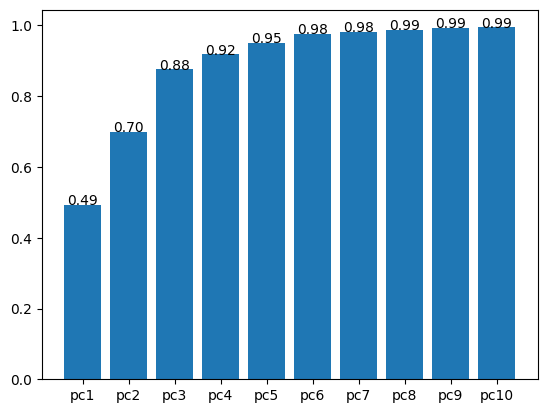

In [32]:
n_components = 10
pca = PCA(n_components=n_components).fit(data_scaled)

var_ratios_cum = np.tri(n_components) @ pca.explained_variance_ratio_
labels = [f"pc{i}" for i in range(1, n_components+1)]

plt.bar(labels, var_ratios_cum)
for i in range(n_components):
    plt.text(i, var_ratios_cum[i], f"{var_ratios_cum[i]:.2f}", ha='center')
# plt.bar(labels, pca.explained_variance_ratio_)

5 principal components capture 90% of the variance, while adding any additional components captures at most ~1%.

In [33]:
n_components = 5
pca = PCA(n_components=n_components).fit(data_scaled)

data_pca = pca.transform(data_scaled)
data_pca

array([[-5.37205535e-01,  1.97571695e-02, -2.29317072e-01,
        -1.92749334e-01, -1.16058310e-02],
       [-7.41623840e-01, -2.74345247e+00,  9.26241413e-01,
         6.29249820e-01,  3.13232729e-02],
       [-5.43898690e-01, -3.08483575e-02, -2.09890284e-01,
        -2.23510019e-01, -5.51170502e-02],
       ...,
       [-6.88318137e-01,  1.18368536e+00,  2.72249078e+00,
        -2.46052607e-01,  1.12818689e-01],
       [-6.81714157e-01,  1.26666005e+00,  2.58932629e+00,
        -1.60860618e-01,  2.19503447e-02],
       [-6.84170577e-01,  1.25723002e+00,  2.58243774e+00,
        -1.09561864e-03,  1.34035345e-01]], shape=(6436, 5))

**Nevertheless, we will evaluate each clustering model with different number of principal components**

## Clustering

For clustering, we will evaluate three separate models:

1. `KMeans`
2. `DBSCAN`
3. `GaussianMixture` (Gaussian Mixture Models, or GMMs)

For each model, a variety of different PCA datasets and hyperparameters will be tried, and the resulting clusters and cluster labels will be tested against our validation set and each other.

Prepare the collection of the evaluation data

In [34]:
# Ensure that the validation genre labels map correctly
song_genre = validation_df.loc[:, ['song_id', 'genre_id']].drop_duplicates()
song_genre = pd.merge(pd.DataFrame(data_scaled.index), song_genre, on='song_id')

RANDOM_STATE = 42

poss_principal_components = range(3, 6)

# model_metrics_columns = [ 
#     "model",
#     "hyperparameters",
#     "n_components",
#     "inertia",
#     "silhouette_score",
#     "homogeneity_score",
#     "completeness_score",    
# ]

Generate each pca datasets

In [35]:
pca_datasets = []
for n_components in poss_principal_components:
    pca_dataset = PCA(
            n_components=n_components
        ).fit_transform(data_scaled)
    pca_datasets.append(pca_dataset)

### Clustering with `KMeans`

In [36]:
max_clusters = validation_df.genre_id.max() + 1
# From .5 - 1.5 times the number of genres: super-genres and sub-genres
poss_clusters = range(8, max_clusters+9)

model_metrics = [[]] * len(pca_datasets) * len(poss_clusters)
row_index = 0


for n_components, pca_dataset in zip(poss_principal_components, pca_datasets):
    inertia = []
    silhouette = []
    
    for n_clusters in poss_clusters:
        kmeans = KMeans(
            n_clusters=n_clusters,
            random_state=RANDOM_STATE
        ).fit(pca_dataset)   
            
        # Store the cluster labeling by each model
        model_name = "kmeans"
        model_id = f"{model_name}_nclusters={n_clusters}_ncomponents={n_components}"
        song_genre.loc[:, model_id] = kmeans.labels_
        
        # Evaluation
        model_metrics[row_index] = [
            model_name,
            n_clusters, # hyperparameter
            n_components,
            kmeans.inertia_,
            silhouette_score(data_pca, kmeans.labels_),
            homogeneity_score(song_genre.genre_id, kmeans.labels_),
            completeness_score(song_genre.genre_id, kmeans.labels_)
        ]
        row_index += 1

Store evaluation metrics

In [37]:
columns = [ 
    "model",
    "clusters",
    "n_components",
    "inertia",
    "silhouette_score",
    "homogeneity_score",
    "completeness_score",    
]
kmeans_eval_df = pd.DataFrame(model_metrics, columns=columns)
kmeans_eval_df.head()

,model,clusters,n_components,inertia,silhouette_score,homogeneity_score,completeness_score
0,kmeans,8,3,152.201131,0.403785,0.047424,0.054122
1,kmeans,9,3,125.794225,0.404442,0.047651,0.054295
2,kmeans,10,3,112.424552,0.379433,0.049203,0.053885
3,kmeans,11,3,88.950596,0.308175,0.049581,0.046696
4,kmeans,12,3,78.174989,0.257738,0.052185,0.044578


#### Evaluations

Evaluate how the number of principal components affects the performance of the `KMeans` algorithm

In [38]:
metrics = ['inertia', 'silhouette_score', 'homogeneity_score', 'completeness_score']

Text(0.5, 0.98, 'Evaluation Metric Score by Number of Principal Components')

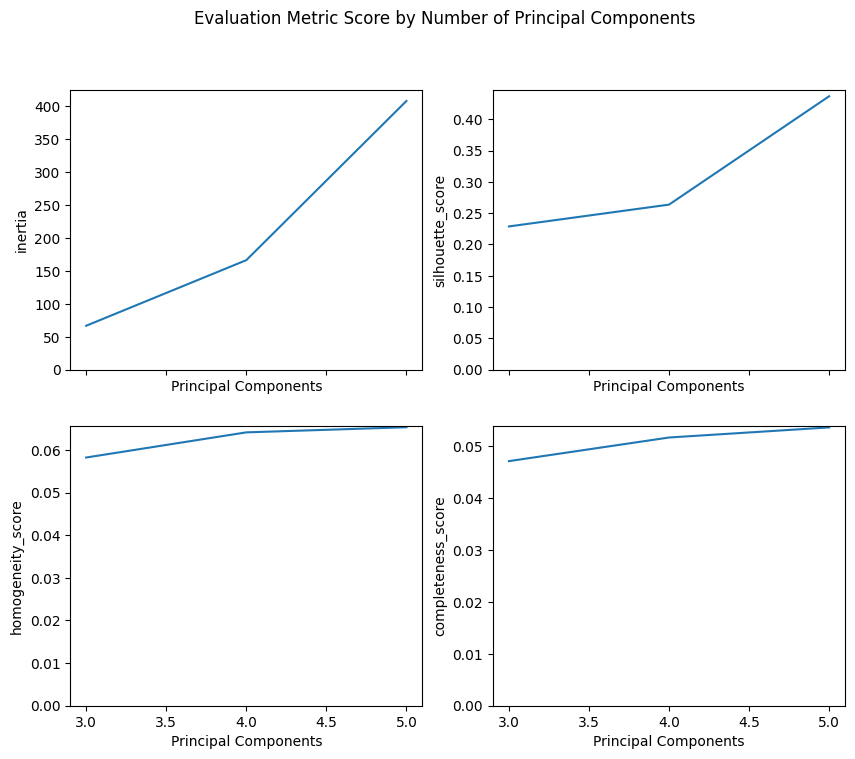

In [39]:
# Average performance by principal components
perf_by_components = kmeans_eval_df.loc[:, ['n_components'] + metrics].groupby('n_components').mean()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), sharex=True)
x = perf_by_components.index
iteration = 0

for i in range(2):
    for j in range(2):
        # Access current axis
        ax = axs[i, j]
        
        # Assign current metric
        metric = metrics[iteration]
        
        # Plot data inside each chart        
        y = perf_by_components.loc[:, metric]        
        ax.plot(x, y)
        
        # Update figure axes and labels       
        ax.set_ylim(0)
        ax.set_ylabel(metric)
        ax.set_xlabel("Principal Components")
        
        
        iteration += 1

fig.suptitle("Evaluation Metric Score by Number of Principal Components")

Evaluate the effect of the number of clusters on performance

Text(0.5, 0.98, 'Evaluation Metric Score by Number of Clusters')

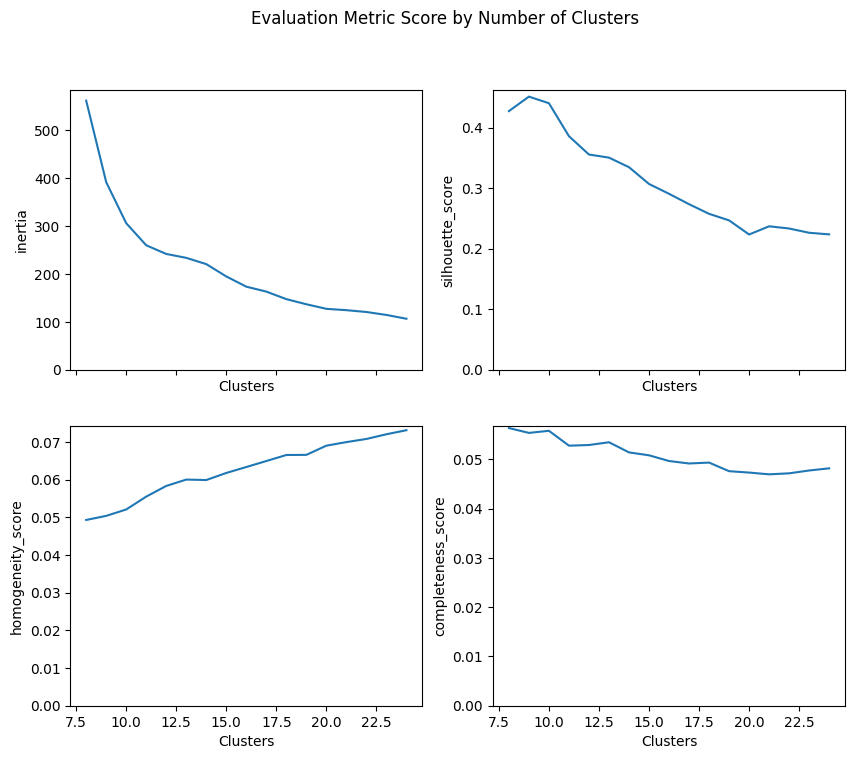

In [40]:
# Average performance by principal components
perf_by_cluster = kmeans_eval_df.loc[:, ['clusters'] + metrics].groupby('clusters').mean()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), sharex=True)
x = perf_by_cluster.index
iteration = 0

for i in range(2):
    for j in range(2):
        # Access current axis
        ax = axs[i, j]
        
        # Assign current metric
        metric = metrics[iteration]
        
        # Plot data inside each chart        
        y = perf_by_cluster.loc[:, metric]        
        ax.plot(x, y)
        
        # Update figure axes and labels       
        ax.set_ylim(0)
        ax.set_ylabel(metric)
        ax.set_xlabel("Clusters")
        
        
        iteration += 1

fig.suptitle("Evaluation Metric Score by Number of Clusters")

Evaluate how the number of clusters and number of components affect performance

Text(0.5, 0.98, 'Evaluation Metric Score by Number of Principal Components & Clusters')

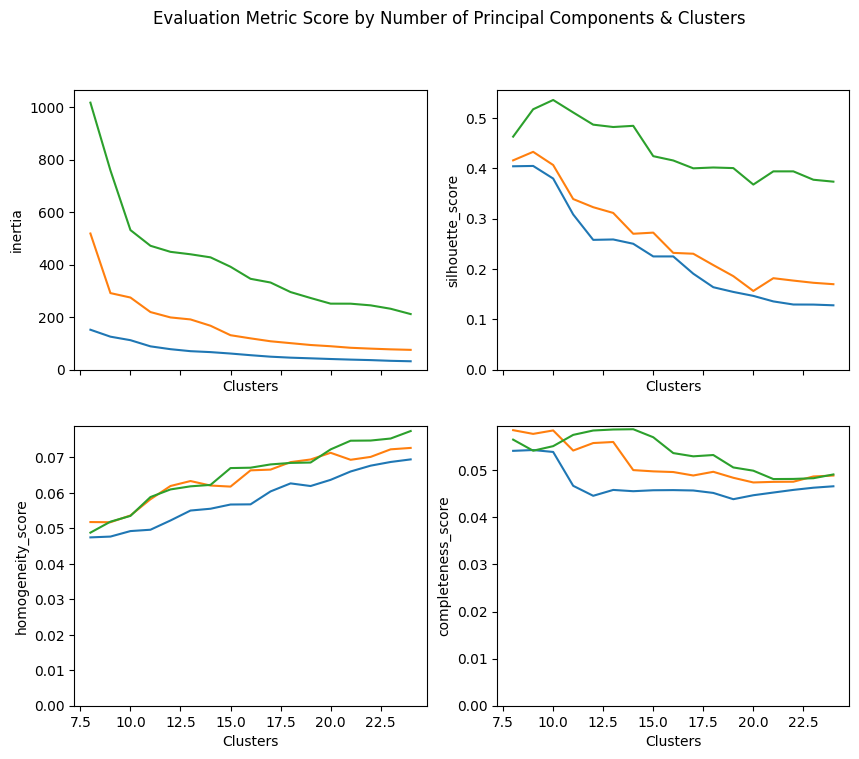

In [41]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), sharex=True)
x = kmeans_eval_df.clusters.unique()
iteration = 0

for i in range(2):
    for j in range(2):
        # Access current axis
        ax = axs[i, j]
        
        # Assign current metric
        metric = metrics[iteration]
        
        # Plot data inside each chart
        for n_components in kmeans_eval_df.loc[:, 'n_components'].unique():
            y = kmeans_eval_df.loc[kmeans_eval_df.loc[:, 'n_components'] == n_components, metric]
            ax.plot(x, y, label=f"{n_components} Principal Components")
        
        # Update figure axes and labels       
        ax.set_ylim(0)
        ax.set_ylabel(metric)
        ax.set_xlabel('Clusters')
        
        iteration += 1

fig.suptitle("Evaluation Metric Score by Number of Principal Components & Clusters")

### Clustering with `DBSCAN`

In [42]:
eps_list = np.arange(.25, .875, .125)
min_samples_list = range(1, 10, 2)

model_metrics = [[]] * len(poss_principal_components) * len(eps_list) * len(min_samples_list)
# print(len(model_metrics))
row_index = 0

for n_components, pca_dataset in zip(poss_principal_components, pca_datasets):
    for eps in eps_list:
        for min_samples in min_samples_list:
            dbscan = DBSCAN(
                eps=np.round(eps, 1), # .3 in eps_list was returned with a floating point error
                min_samples=min_samples,
                n_jobs=-1
            ).fit(pca_dataset)            
            
            # Store the cluster labeling by each model
            model_name = "dbscan"
            model_id = f"{model_name}_eps={eps}_minsamples={min_samples}_ncomponents={n_components}"
            song_genre.loc[:, model_id] = dbscan.labels_
            
            # Generate 1 metrics row per model
            model_metrics[row_index] = [
                model_name,
                eps, # hyperparameters
                min_samples, # hyperparameters
                n_components,
                silhouette_score(data_pca, dbscan.labels_),
                homogeneity_score(song_genre.genre_id, dbscan.labels_),
                completeness_score(song_genre.genre_id, dbscan.labels_)
            ]
            
            row_index += 1

C:\Users\chris\AppData\Local\Temp\ipykernel_20820\1208243362.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  song_genre.loc[:, model_id] = dbscan.labels_
C:\Users\chris\AppData\Local\Temp\ipykernel_20820\1208243362.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  song_genre.loc[:, model_id] = dbscan.labels_
C:\Users\chris\AppData\Local\Temp\ipykernel_20820\1208243362.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

Store evaluation metrics

In [43]:
columns = [ 
    "model",
    "eps",
    "min_samples",
    "n_components",
    "silhouette_score",
    "homogeneity_score",
    "completeness_score",    
]
dbscan_eval_df = pd.DataFrame(model_metrics, columns=columns)
dbscan_eval_df.head()

,model,eps,min_samples,n_components,silhouette_score,homogeneity_score,completeness_score
0,dbscan,0.25,1,3,0.573011,0.032472,0.060368
1,dbscan,0.25,3,3,0.833102,0.031046,0.057944
2,dbscan,0.25,5,3,0.833102,0.031046,0.057944
3,dbscan,0.25,7,3,0.832279,0.030893,0.057632
4,dbscan,0.25,9,3,0.831716,0.030898,0.057629


#### Evaluations

In [44]:
metrics = ['silhouette_score', 'homogeneity_score', 'completeness_score']

##### Evaluating one hyperparameter at a time

Evaluate effect of the number of principal components on the model

Text(0.5, 0.98, 'DBSCAN Evaluation Metric Score by Number of Principal Components')

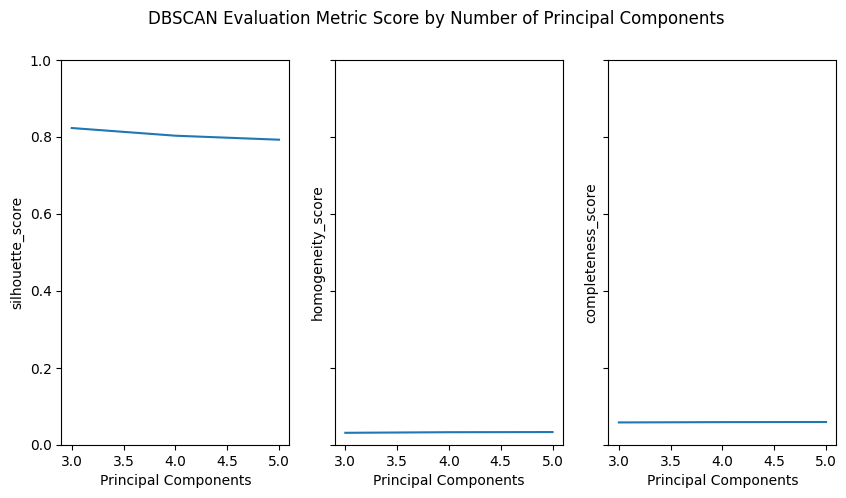

In [45]:
# Average performance by principal components
perf_by_components = dbscan_eval_df.loc[:, ['n_components'] + metrics].groupby('n_components').mean()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5), sharex=True, sharey=True)
x = perf_by_components.index

for i in range(3):
    # Access current axis
    ax = axs[i]
    
    # Assign current metric
    metric = metrics[i]
    
    # Plot data inside each chart        
    y = perf_by_components.loc[:, metric]        
    ax.plot(x, y)
    
    # Update figure axes and labels       
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)
    ax.set_xlabel("Principal Components")

fig.suptitle(f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components")

Evaluate the effect of eps on model performance

Text(0.5, 0.98, 'DBSCAN Evaluation Metric Score by eps Value')

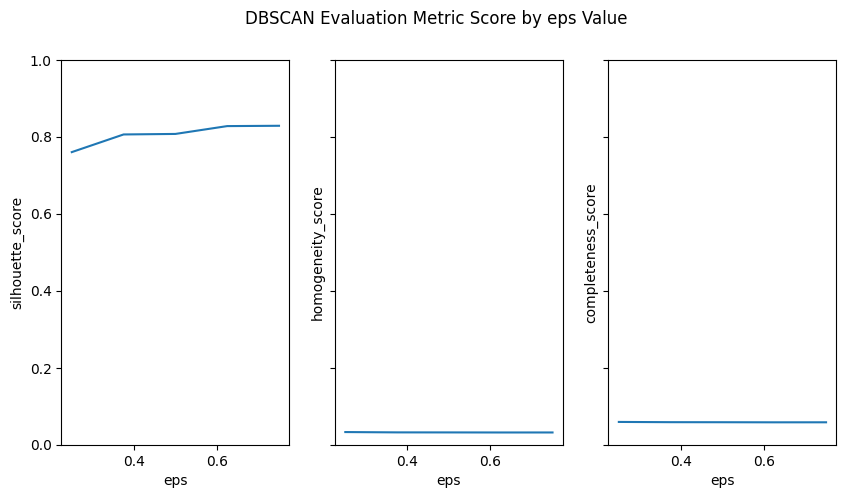

In [46]:
# Average performance by principal components
perf_by_components = dbscan_eval_df.loc[:, ['eps'] + metrics].groupby('eps').mean()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5), sharex=True, sharey=True)
x = perf_by_components.index

for i in range(3):
    # Access current axis
    ax = axs[i]
    
    # Assign current metric
    metric = metrics[i]
    
    # Plot data inside each chart        
    y = perf_by_components.loc[:, metric]        
    ax.plot(x, y)
    
    # Update figure axes and labels       
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)
    ax.set_xlabel("eps")

fig.suptitle(f"{model_name.upper()} Evaluation Metric Score by eps Value")

Evaluate the effect of `min_samples` on model performance

Text(0.5, 0.98, 'DBSCAN Evaluation Metric Score by Number of Min Samples')

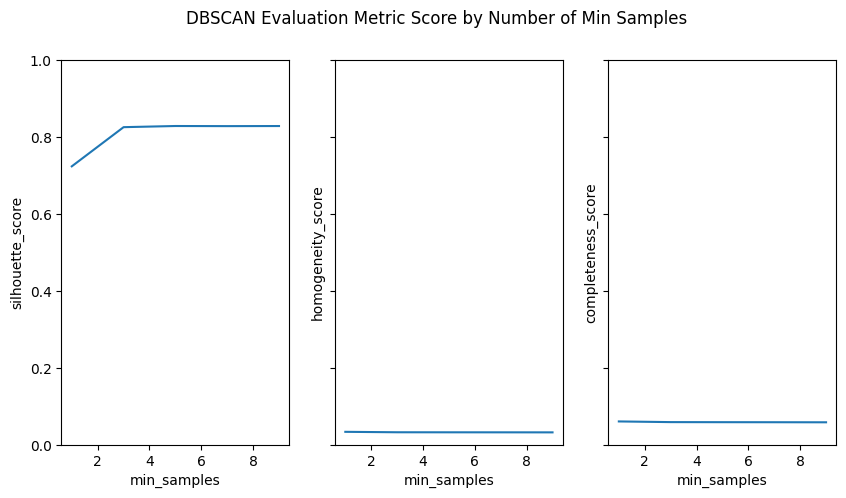

In [47]:
# Average performance by principal components
perf_by_components = dbscan_eval_df.loc[:, ['min_samples'] + metrics].groupby('min_samples').mean()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5), sharex=True, sharey=True)
x = perf_by_components.index

for i in range(3):
    # Access current axis
    ax = axs[i]
    
    # Assign current metric
    metric = metrics[i]
    
    # Plot data inside each chart        
    y = perf_by_components.loc[:, metric]        
    ax.plot(x, y)
    
    # Update figure axes and labels       
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)
    ax.set_xlabel("min_samples")

fig.suptitle(f"{model_name.upper()} Evaluation Metric Score by Number of Min Samples")

##### Evaluating two hyperparameters at a time

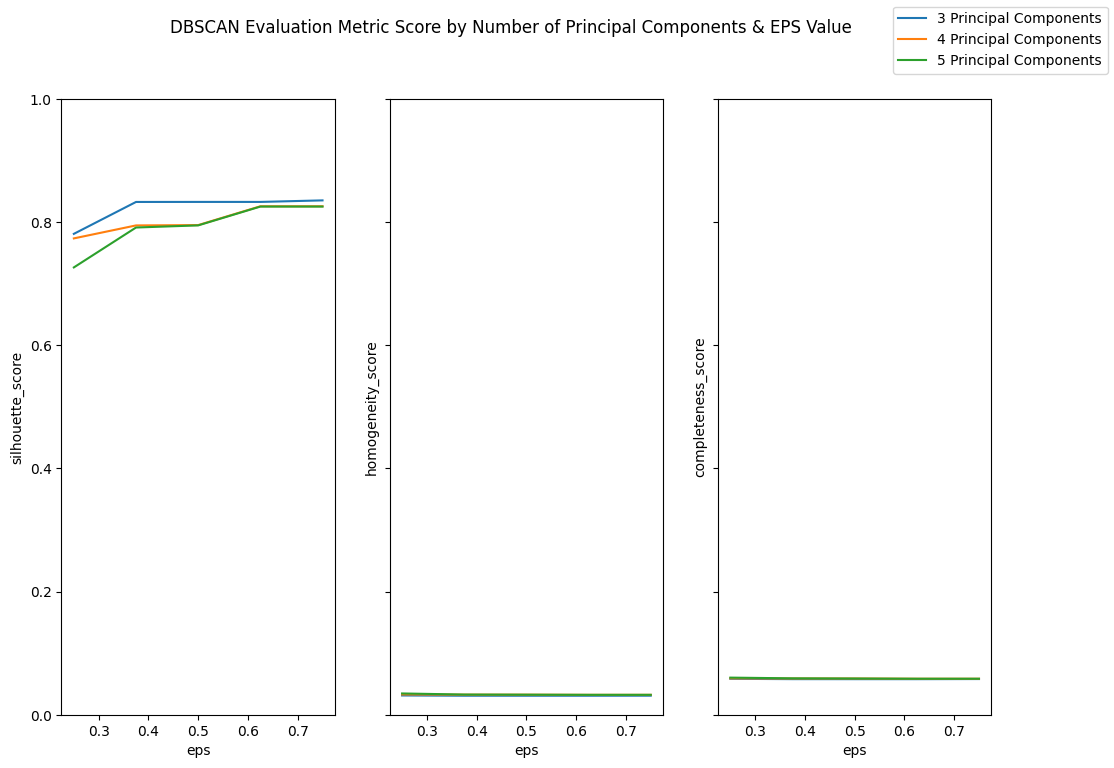

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,8), sharex=True, sharey=True)
x = dbscan_eval_df.eps.unique()
hyperparameter = 'eps'

for i in range(3):
    # Access current axis
    ax = axs[i]
    
    # Assign current metric
    metric = metrics[i]
    
    # Plot data inside each chart
    for n_components in dbscan_eval_df.loc[:, 'n_components'].unique():
        y = dbscan_eval_df.loc[dbscan_eval_df.loc[:, 'n_components'] == n_components, [hyperparameter, metric]].groupby(hyperparameter).mean()
        ax.plot(x, y, label=f"{n_components} Principal Components" if i == 2 else "")
    
    # Update figure axes and labels       
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)
    ax.set_xlabel('eps')

fig.suptitle(f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components & EPS Value")
fig.legend()

Evaluate the effect of `min_samples` and the number of principal components on model performance

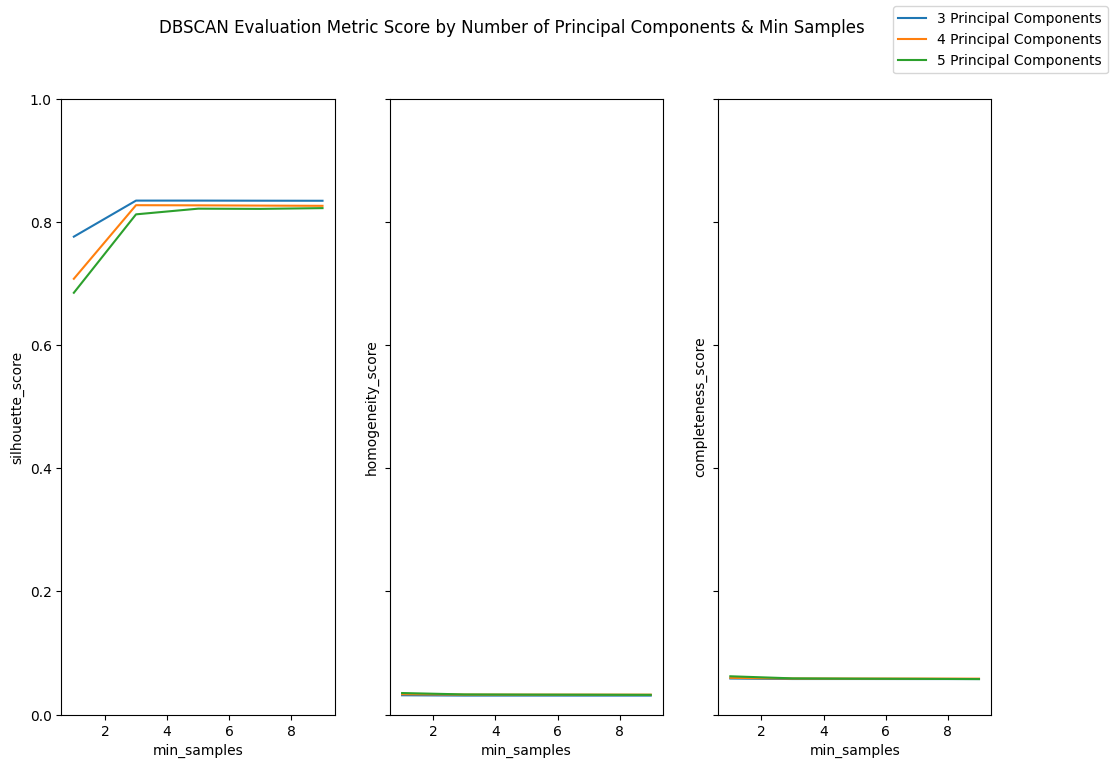

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,8), sharex=True, sharey=True)
x = dbscan_eval_df.min_samples.unique()
hyperparameter = 'min_samples'

for i in range(3):
    # Access current axis
    ax = axs[i]
    
    # Assign current metric
    metric = metrics[i]
    
    # Plot data inside each chart
    for n_components in dbscan_eval_df.loc[:, 'n_components'].unique():
        y = dbscan_eval_df.loc[dbscan_eval_df.loc[:, 'n_components'] == n_components, [hyperparameter, metric]].groupby(hyperparameter).mean()
        ax.plot(x, y, label=f"{n_components} Principal Components" if i == 2 else "") # Only add labels to the legend in final loop to avoid duplicates
    
    # Update figure axes and labels       
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)
    ax.set_xlabel('min_samples')

fig.suptitle(f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components & Min Samples")
fig.legend()

Evaluate the effect of `min_samples` and `eps` on model performance

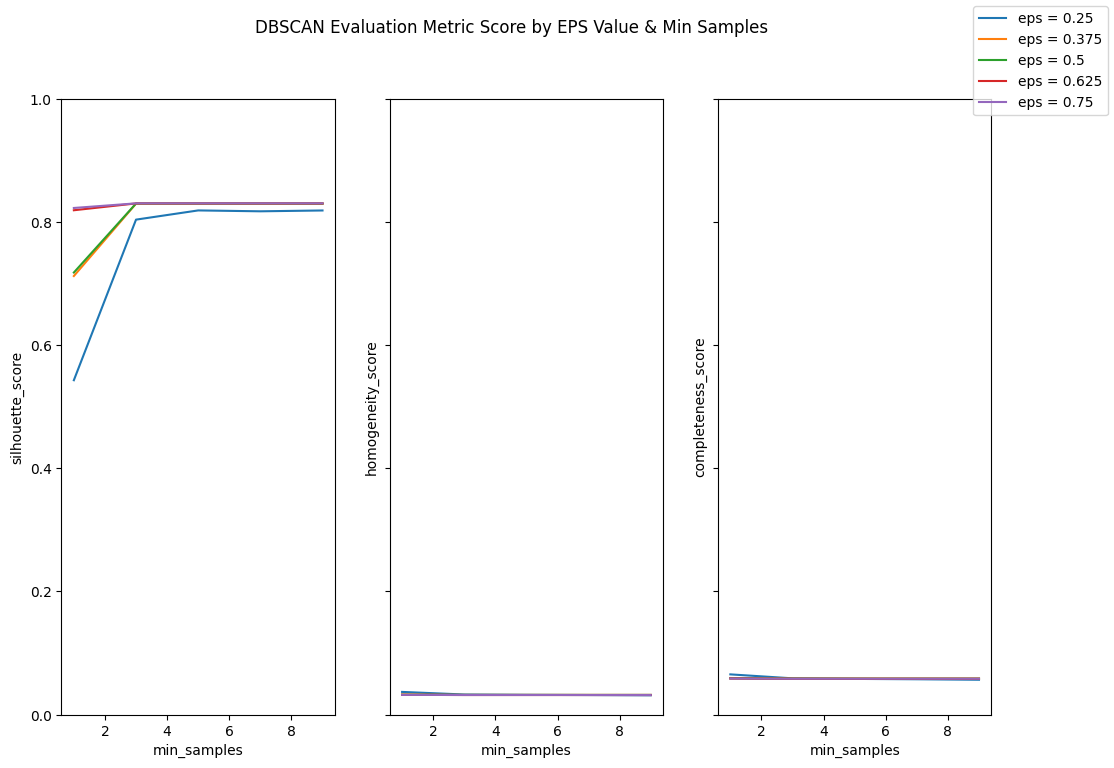

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,8), sharex=True, sharey=True)
x = dbscan_eval_df.min_samples.unique()
hyperparameter = 'min_samples'

for i in range(3):
    # Access current axis
    ax = axs[i]
    
    # Assign current metric
    metric = metrics[i]
    
    # Plot data inside each chart
    for eps in dbscan_eval_df.loc[:, 'eps'].unique():
        y = dbscan_eval_df.loc[dbscan_eval_df.loc[:, 'eps'] == eps, [hyperparameter, metric]].groupby(hyperparameter).mean()
        ax.plot(x, y, label=f"eps = {eps}" if i == 2 else "") # Only add labels to the legend in final loop to avoid duplicates
    
    # Update figure axes and labels       
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)
    ax.set_xlabel('min_samples')

fig.suptitle(f"{model_name.upper()} Evaluation Metric Score by EPS Value & Min Samples")
fig.legend()

### Clustering with `GaussianMixture`

In [51]:
n_mixture_components = range(1,6)
covariance_types = ['full', 'tied', 'diag', 'spherical']

model_metrics = [[]] * len(pca_datasets) * len(n_mixture_components) * len(covariance_types)
row_index = 0

gmm_models_skipped = []

for n_components, pca_dataset in zip(poss_principal_components, pca_datasets):
    for covariance_type in covariance_types:
        for mixture_components in n_mixture_components:
            gmm = GaussianMixture(
                n_components=mixture_components,
                covariance_type=covariance_type,
                random_state=RANDOM_STATE
            ).fit(pca_dataset)   
                
            # Store the cluster labeling by each model
            model_name = "gmm"
            model_id = f"{model_name}_covariancetype={covariance_type}_mixturecomponents={mixture_components}_ncomponents={n_components}"
            labels = gmm.predict(pca_dataset)
            
            # Some models only assign data to 1 cluster, which throws an error for the silhouette_score
            if len(set(labels)) == 1:
                gmm_models_skipped.append(model_id)
                continue
            
            song_genre.loc[:, model_id] = labels
            
            # Evaluation
            model_metrics[row_index] = [
                model_name,
                covariance_type, # hyperparameter
                mixture_components, # hyperparameter
                n_components,
                silhouette_score(data_pca, labels),
                homogeneity_score(song_genre.genre_id, labels),
                completeness_score(song_genre.genre_id, labels)
            ]
            row_index += 1

print(f"{len(gmm_models_skipped)} out of {len(model_metrics)} models were skipped:")
print(gmm_models_skipped)

model_metrics = [full_row for full_row in model_metrics if len(full_row) > 0]

C:\Users\chris\AppData\Local\Temp\ipykernel_20820\2359642359.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  song_genre.loc[:, model_id] = labels
C:\Users\chris\AppData\Local\Temp\ipykernel_20820\2359642359.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  song_genre.loc[:, model_id] = labels
C:\Users\chris\AppData\Local\Temp\ipykernel_20820\2359642359.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

12 out of 60 models were skipped:
['gmm_covariancetype=full_mixturecomponents=1_ncomponents=3', 'gmm_covariancetype=tied_mixturecomponents=1_ncomponents=3', 'gmm_covariancetype=diag_mixturecomponents=1_ncomponents=3', 'gmm_covariancetype=spherical_mixturecomponents=1_ncomponents=3', 'gmm_covariancetype=full_mixturecomponents=1_ncomponents=4', 'gmm_covariancetype=tied_mixturecomponents=1_ncomponents=4', 'gmm_covariancetype=diag_mixturecomponents=1_ncomponents=4', 'gmm_covariancetype=spherical_mixturecomponents=1_ncomponents=4', 'gmm_covariancetype=full_mixturecomponents=1_ncomponents=5', 'gmm_covariancetype=tied_mixturecomponents=1_ncomponents=5', 'gmm_covariancetype=diag_mixturecomponents=1_ncomponents=5', 'gmm_covariancetype=spherical_mixturecomponents=1_ncomponents=5']


Store evaluation metrics

In [52]:
columns = [ 
    "model",
    "covariance_type",
    "mixture_components",
    "n_components",
    "silhouette_score",
    "homogeneity_score",
    "completeness_score",    
]
gmm_eval_df = pd.DataFrame(model_metrics, columns=columns)
gmm_eval_df.head()

,model,covariance_type,mixture_components,n_components,silhouette_score,homogeneity_score,completeness_score
0,gmm,full,2,3,0.692077,0.011501,0.042217
1,gmm,full,3,3,0.756918,0.020724,0.052379
2,gmm,full,4,3,0.820454,0.024908,0.048705
3,gmm,full,5,3,0.828410,0.029625,0.056755
4,gmm,tied,2,3,0.692077,0.011501,0.042217


#### Evaluations

In [53]:
metrics = ['silhouette_score', 'homogeneity_score', 'completeness_score']

##### Functions

In [54]:
def plot_subplots(grouped_df, metrics, title, xlabel, ylim_bounds=(0,1), ncols=3, figsize=(10,5), sharex=True, sharey=True, bar=False):
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=figsize,
                            sharex=sharex, sharey=sharey)
    
    x_data = grouped_df.index
    
    for i in range(ncols):
        # Access current axis
        ax = axs[i]
        
        # Assign current metric
        metric = metrics[i]
        
        # Plot data inside each chart        
        y_data = grouped_df.loc[:, metric]
        if bar:
            ax.bar(x_data, y_data)
        else:
            ax.plot(x_data, y_data)
        
        # Update figure axes and labels       
        ax.set_ylim(ylim_bounds)
        ax.set_ylabel(metric)
        ax.set_xlabel(xlabel)

    fig.suptitle(title)

In [55]:
def plot_subplots_2hparams(grouped_df, hparam1, hparam2, metrics, title,
                           xlabel, ylim_bounds=(0,1), ncols=3, figsize=(10,5),
                           sharex=True, sharey=True, bar=False):
    
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=figsize,
                            sharex=sharex, sharey=sharey)
    
    x_data = grouped_df.loc[:, hparam1].unique()
    
    
    for i in range(ncols):
        # Access current axis
        ax = axs[i]
        
        # Assign current metric
        metric = metrics[i]
                
        # Plot data inside each chart        
        y_data = grouped_df.loc[:, metric]
        # Plot data inside each chart
        for j, hparam2_val in enumerate(grouped_df.loc[:, hparam2].unique()):
            agg = grouped_df.loc[grouped_df.loc[:, hparam2] == hparam2_val, [hparam1, metric]].groupby(hparam1).mean()
            y_data = agg.loc[:, metric]
            
            if bar:
                pass
            else:
                ax.plot(x_data, y_data, label=f"{hparam2_val} {hparam2}" if i == 2 else "")
        
        # Update figure axes and labels       
        ax.set_ylim(ylim_bounds)
        ax.set_ylabel(metric)
        ax.set_xlabel(xlabel)

    fig.suptitle(title)
    fig.legend()

##### Evaluating one hyperparameter at a time

Model performance by number of principal components

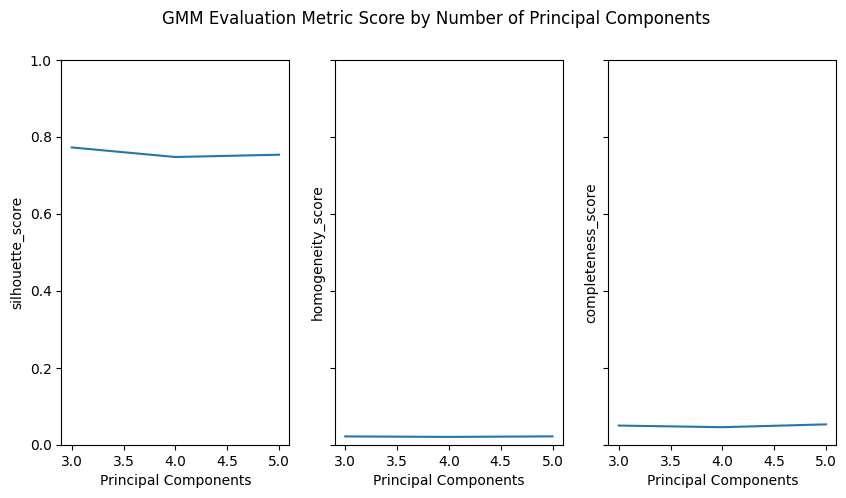

In [56]:
hyperparameter = ['n_components']

# Average performance by principal components
perf_by_components = gmm_eval_df.loc[:, hyperparameter + metrics].groupby(hyperparameter).mean()

plot_subplots(
    grouped_df=perf_by_components,
    metrics=metrics,
    title=f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components",
    xlabel="Principal Components"
)

Performance by number of mixture components

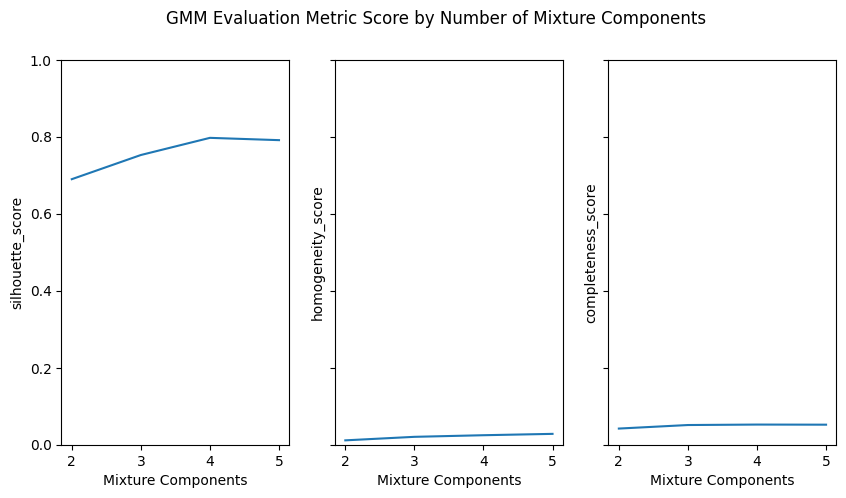

In [57]:
hyperparameter = ['mixture_components']

# Average performance by principal components
perf_by_components = gmm_eval_df.loc[:, hyperparameter + metrics].groupby(hyperparameter).mean()

plot_subplots(
    grouped_df=perf_by_components,
    metrics=metrics,
    title=f"{model_name.upper()} Evaluation Metric Score by Number of Mixture Components",
    xlabel="Mixture Components"
)

Performance by covariance type

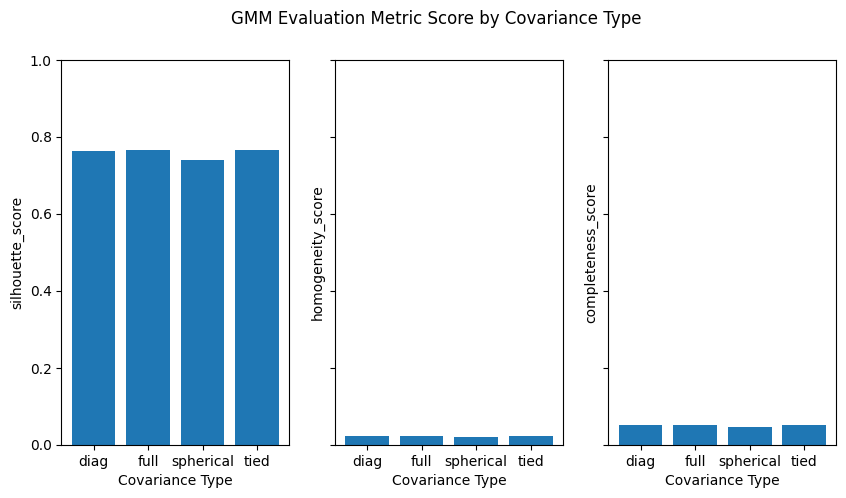

In [58]:
hyperparameter = ['covariance_type']

# Average performance by principal components
perf_by_components = gmm_eval_df.loc[:, hyperparameter + metrics].groupby(hyperparameter).mean()

plot_subplots(
    grouped_df=perf_by_components,
    metrics=metrics,
    title=f"{model_name.upper()} Evaluation Metric Score by Covariance Type",
    xlabel="Covariance Type",
    bar=True
)

##### Evaluating two hyperparameters at a time

by number of principal components and mixture components

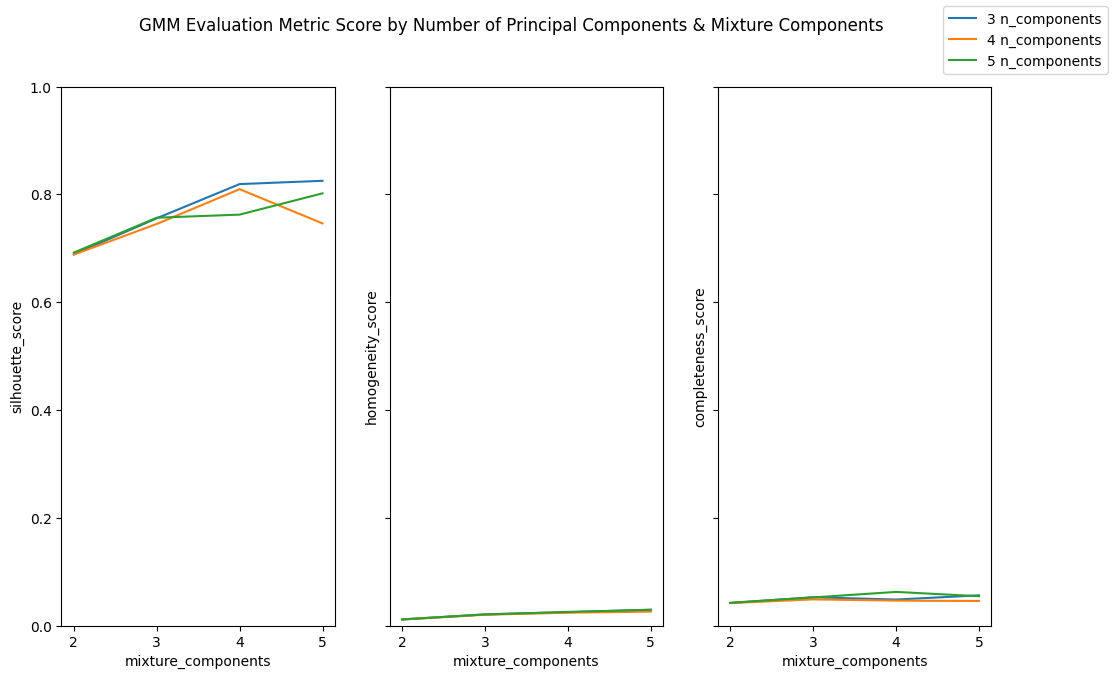

In [59]:
plot_subplots_2hparams(
    grouped_df=gmm_eval_df,
    hparam1='mixture_components',
    hparam2='n_components',
    metrics=metrics,
    title=f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components & Mixture Components",
    xlabel="mixture_components",
    figsize=(12, 7)
)

by `covariance_type` and number of mixture components

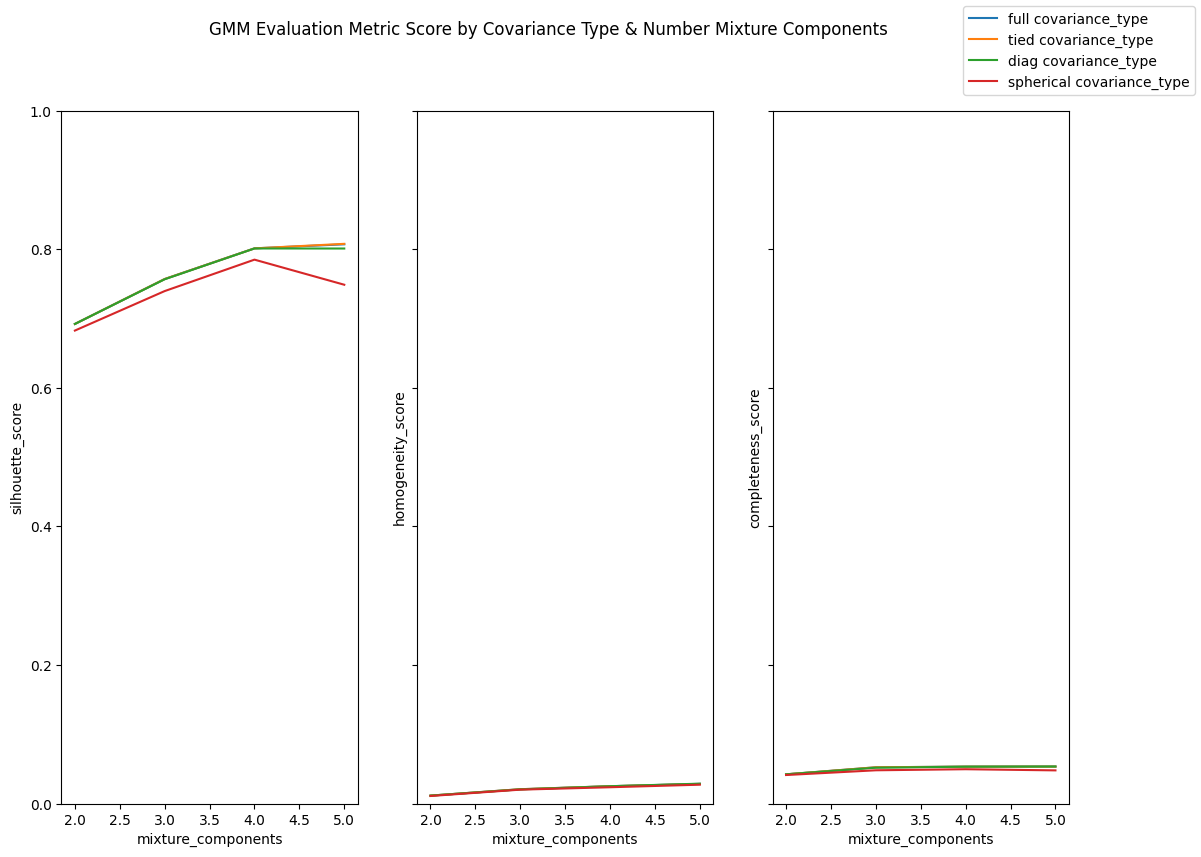

In [60]:
plot_subplots_2hparams(
    grouped_df=gmm_eval_df,
    hparam1='mixture_components',
    hparam2='covariance_type',
    metrics=metrics,
    title=f"{model_name.upper()} Evaluation Metric Score by Covariance Type & Number Mixture Components",
    xlabel="mixture_components",
    figsize=(13, 9)
)

by `covariance_type` and number of principal components

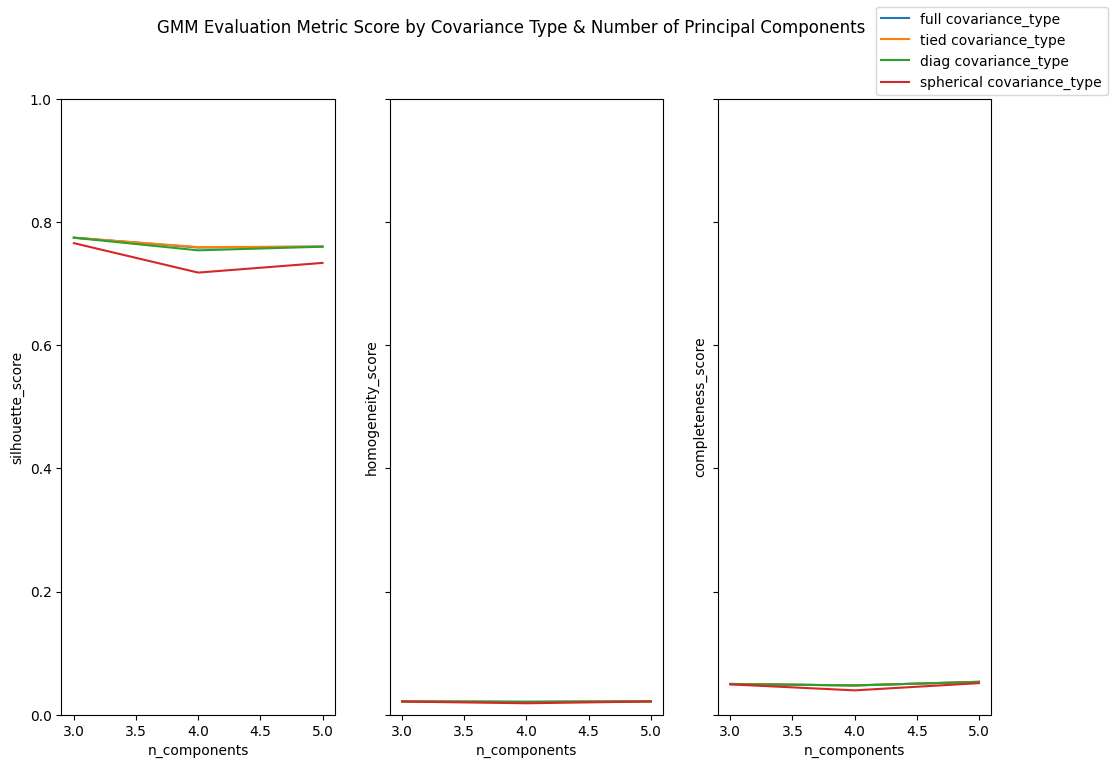

In [61]:
plot_subplots_2hparams(
    grouped_df=gmm_eval_df,
    hparam1='n_components',
    hparam2='covariance_type',
    metrics=metrics,
    title=f"{model_name.upper()} Evaluation Metric Score by Covariance Type & Number of Principal Components",
    xlabel="n_components",
    figsize=(12, 8)
)

### Cross model comparisons

In [ ]:
song_genre.head()

,song_id,genre_id,kmeans_nclusters=8_ncomponents=3,kmeans_nclusters=9_ncomponents=3,kmeans_nclusters=10_ncomponents=3,kmeans_nclusters=11_ncomponents=3,kmeans_nclusters=12_ncomponents=3,kmeans_nclusters=13_ncomponents=3,kmeans_nclusters=14_ncomponents=3,kmeans_nclusters=15_ncomponents=3,kmeans_nclusters=16_ncomponents=3,kmeans_nclusters=17_ncomponents=3,kmeans_nclusters=18_ncomponents=3,kmeans_nclusters=19_ncomponents=3,kmeans_nclusters=20_ncomponents=3,kmeans_nclusters=21_ncomponents=3,kmeans_nclusters=22_ncomponents=3,kmeans_nclusters=23_ncomponents=3,kmeans_nclusters=24_ncomponents=3,kmeans_nclusters=8_ncomponents=4,kmeans_nclusters=9_ncomponents=4,kmeans_nclusters=10_ncomponents=4,kmeans_nclusters=11_ncomponents=4,kmeans_nclusters=12_ncomponents=4,kmeans_nclusters=13_ncomponents=4,kmeans_nclusters=14_ncomponents=4,kmeans_nclusters=15_ncomponents=4,kmeans_nclusters=16_ncomponents=4,kmeans_nclusters=17_ncomponents=4,kmeans_nclusters=18_ncomponents=4,kmeans_nclusters=19_ncomponents=4,kmeans_nclusters=20_ncomponents=4,kmeans_nclusters=21_ncomponents=4,kmeans_nclusters=22_ncomponents=4,kmeans_nclusters=23_ncomponents=4,kmeans_nclusters=24_ncomponents=4,kmeans_nclusters=8_ncomponents=5,kmeans_nclusters=9_ncomponents=5,kmeans_nclusters=10_ncomponents=5,kmeans_nclusters=11_ncomponents=5,kmeans_nclusters=12_ncomponents=5,kmeans_nclusters=13_ncomponents=5,kmeans_nclusters=14_ncomponents=5,kmeans_nclusters=15_ncomponents=5,kmeans_nclusters=16_ncomponents=5,kmeans_nclusters=17_ncomponents=5,kmeans_nclusters=18_ncomponents=5,kmeans_nclusters=19_ncomponents=5,kmeans_nclusters=20_ncomponents=5,kmeans_nclusters=21_ncomponents=5,kmeans_nclusters=22_ncomponents=5,kmeans_nclusters=23_ncomponents=5,kmeans_nclusters=24_ncomponents=5,dbscan_eps=0.25_minsamples=1_ncomponents=3,dbscan_eps=0.25_minsamples=3_ncomponents=3,dbscan_eps=0.25_minsamples=5_ncomponents=3,dbscan_eps=0.25_minsamples=7_ncomponents=3,dbscan_eps=0.25_minsamples=9_ncomponents=3,dbscan_eps=0.375_minsamples=1_ncomponents=3,dbscan_eps=0.375_minsamples=3_ncomponents=3,dbscan_eps=0.375_minsamples=5_ncomponents=3,dbscan_eps=0.375_minsamples=7_ncomponents=3,dbscan_eps=0.375_minsamples=9_ncomponents=3,dbscan_eps=0.5_minsamples=1_ncomponents=3,dbscan_eps=0.5_minsamples=3_ncomponents=3,dbscan_eps=0.5_minsamples=5_ncomponents=3,dbscan_eps=0.5_minsamples=7_ncomponents=3,dbscan_eps=0.5_minsamples=9_ncomponents=3,dbscan_eps=0.625_minsamples=1_ncomponents=3,dbscan_eps=0.625_minsamples=3_ncomponents=3,dbscan_eps=0.625_minsamples=5_ncomponents=3,dbscan_eps=0.625_minsamples=7_ncomponents=3,dbscan_eps=0.625_minsamples=9_ncomponents=3,dbscan_eps=0.75_minsamples=1_ncomponents=3,dbscan_eps=0.75_minsamples=3_ncomponents=3,dbscan_eps=0.75_minsamples=5_ncomponents=3,dbscan_eps=0.75_minsamples=7_ncomponents=3,dbscan_eps=0.75_minsamples=9_ncomponents=3,dbscan_eps=0.25_minsamples=1_ncomponents=4,dbscan_eps=0.25_minsamples=3_ncomponents=4,dbscan_eps=0.25_minsamples=5_ncomponents=4,dbscan_eps=0.25_minsamples=7_ncomponents=4,dbscan_eps=0.25_minsamples=9_ncomponents=4,dbscan_eps=0.375_minsamples=1_ncomponents=4,dbscan_eps=0.375_minsamples=3_ncomponents=4,dbscan_eps=0.375_minsamples=5_ncomponents=4,dbscan_eps=0.375_minsamples=7_ncomponents=4,dbscan_eps=0.375_minsamples=9_ncomponents=4,dbscan_eps=0.5_minsamples=1_ncomponents=4,dbscan_eps=0.5_minsamples=3_ncomponents=4,dbscan_eps=0.5_minsamples=5_ncomponents=4,dbscan_eps=0.5_minsamples=7_ncomponents=4,dbscan_eps=0.5_minsamples=9_ncomponents=4,dbscan_eps=0.625_minsamples=1_ncomponents=4,dbscan_eps=0.625_minsamples=3_ncomponents=4,dbscan_eps=0.625_minsamples=5_ncomponents=4,dbscan_eps=0.625_minsamples=7_ncomponents=4,dbscan_eps=0.625_minsamples=9_ncomponents=4,dbscan_eps=0.75_minsamples=1_ncomponents=4,dbscan_eps=0.75_minsamples=3_ncomponents=4,dbscan_eps=0.75_minsamples=5_ncomponents=4,dbscan_eps=0.75_minsamples=7_ncomponents=4,dbscan_eps=0.75_minsamples=9_ncomponents=4,dbscan_eps=0.25_minsamples=1_ncomponents=5,dbscan_eps=0.25_minsamples=3_ncomponents=5,dbscan_e

### Old

Clustering with `KMeans`

In [ ]:
max_clusters = validation_df.genre_id.max() + 1
# From .5 - 1.5 times the number of genres
poss_clusters = range(8, max_clusters+9)

inertia = []
silhouette = []

for n_clusters in poss_clusters:
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=42
    ).fit(data_pca)
    
    labels = kmeans.predict(data_pca)
    
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(data_pca, labels))

kmeans_eval_df = pd.DataFrame({
    'n_clusters': poss_clusters,
    'inertia': inertia,
    'silhouette_score': silhouette
})

kmeans_eval_df

,n_clusters,inertia,silhouette_score
0,8,2280.296563,0.624613
1,9,1381.027952,0.631806
2,10,1247.446834,0.619794
3,11,1128.012181,0.568228
4,12,1101.783110,0.555266
5,13,1019.992759,0.540050
6,14,742.140146,0.472515
7,15,611.407346,0.473472
8,16,548.482632,0.419473
9,17,533.899892,0.414625


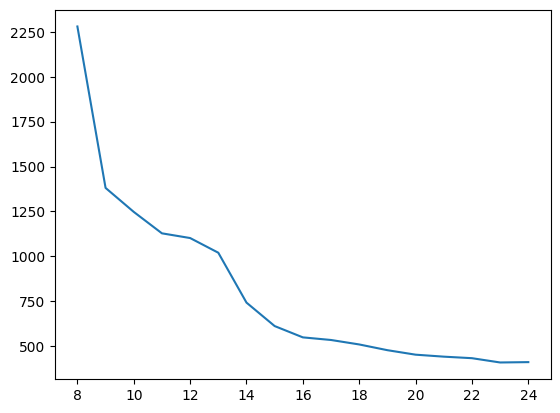

In [ ]:
plt.plot(kmeans_eval_df.n_clusters, kmeans_eval_df.inertia)

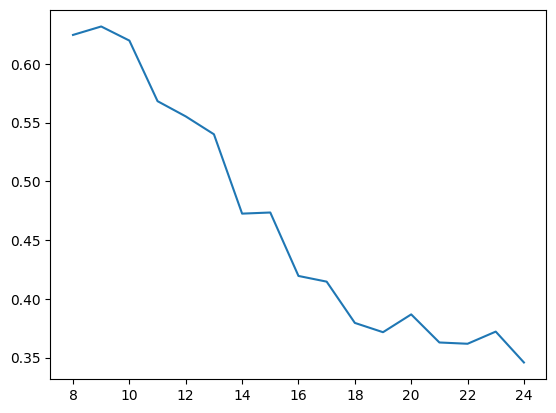

In [ ]:
plt.plot(kmeans_eval_df.n_clusters, kmeans_eval_df.silhouette_score)

Evaluating multiple principal component and cluster values

In [ ]:
poss_principal_components = range(3,7)
kmeans_eval_dfs = []


for n_components in poss_principal_components:
    inertia = []
    silhouette = []
    
    data_pca = PCA(n_components=n_components).fit_transform(data_scaled)
    
    for n_clusters in poss_clusters:
        kmeans = KMeans(
            n_clusters=n_clusters,
            random_state=42
        ).fit(data_pca)
    
        # labels = kmeans.predict(data_pca)       
            
        # Store the cluster labeling by each model
        model_name = f"kmeans_pca={n_components}_nclusters={n_clusters}"
        song_genre.loc[:, model_name] = kmeans.labels_
        print(model_name)
        
        # Evaluation
        inertia.append(kmeans.inertia_)
        silhouette.append(silhouette_score(data_pca, kmeans.labels_))

    kmeans_eval_dfs.append(pd.DataFrame({
        f'{n_components}_inertia': inertia,
        f'{n_components}_silhouette_score': silhouette
    }))

kmeans_eval_dfs

kmeans_pca=3_nclusters=8
kmeans_pca=3_nclusters=9
kmeans_pca=3_nclusters=10
kmeans_pca=3_nclusters=11
kmeans_pca=3_nclusters=12
kmeans_pca=3_nclusters=13
kmeans_pca=3_nclusters=14
kmeans_pca=3_nclusters=15
kmeans_pca=3_nclusters=16
kmeans_pca=3_nclusters=17
kmeans_pca=3_nclusters=18
kmeans_pca=3_nclusters=19
kmeans_pca=3_nclusters=20
kmeans_pca=3_nclusters=21
kmeans_pca=3_nclusters=22
kmeans_pca=3_nclusters=23
kmeans_pca=3_nclusters=24
kmeans_pca=4_nclusters=8
kmeans_pca=4_nclusters=9
kmeans_pca=4_nclusters=10
kmeans_pca=4_nclusters=11
kmeans_pca=4_nclusters=12
kmeans_pca=4_nclusters=13
kmeans_pca=4_nclusters=14
kmeans_pca=4_nclusters=15
kmeans_pca=4_nclusters=16
kmeans_pca=4_nclusters=17
kmeans_pca=4_nclusters=18
kmeans_pca=4_nclusters=19
kmeans_pca=4_nclusters=20
kmeans_pca=4_nclusters=21
kmeans_pca=4_nclusters=22
kmeans_pca=4_nclusters=23
kmeans_pca=4_nclusters=24
kmeans_pca=5_nclusters=8
kmeans_pca=5_nclusters=9
kmeans_pca=5_nclusters=10
kmeans_pca=5_nclusters=11
kmeans_pca=5_nclus

[     3_inertia  3_silhouette_score
 0   266.800968            0.595730
 1   181.662878            0.596357
 2   155.464725            0.610342
 3   133.099487            0.589149
 4   111.043987            0.529245
 5    92.447375            0.529348
 6    90.433600            0.528694
 7    80.882750            0.507894
 8    77.169588            0.492982
 9    70.993824            0.494932
 10   61.358325            0.508104
 11   56.510079            0.508395
 12   53.307954            0.504147
 13   48.109387            0.505547
 14   45.474722            0.498959
 15   44.284672            0.495422
 16   41.787466            0.497524,
      4_inertia  4_silhouette_score
 0   736.060221            0.864526
 1   403.261357            0.701052
 2   353.496449            0.684222
 3   227.759902            0.686367
 4   202.796001            0.678030
 5   160.132975            0.567230
 6   157.374865            0.567201
 7   147.892404            0.551396
 8   144.314836            

In [ ]:
kmeans_eval_grid = pd.concat(kmeans_eval_dfs, axis=1)
kmeans_eval_grid.loc[:, 'n_clusters'] = poss_clusters
kmeans_eval_grid.set_index('n_clusters', inplace=True)
kmeans_eval_grid

,3_inertia,3_silhouette_score,4_inertia,4_silhouette_score,5_inertia,5_silhouette_score,6_inertia,6_silhouette_score
n_clusters,,,,,,,,
8,266.800968,0.595730,736.060221,0.864526,1681.386896,0.752319,2280.296563,0.624613
9,181.662878,0.596357,403.261357,0.701052,665.773694,0.778392,1381.027952,0.631806
10,155.464725,0.610342,353.496449,0.684222,532.801592,0.771376,1247.446834,0.619794
11,133.099487,0.589149,227.759902,0.686367,529.332343,0.768594,1128.012181,0.568228
12,111.043987,0.529245,202.796001,0.678030,398.749277,0.769669,1101.783110,0.555266
13,92.447375,0.529348,160.132975,0.567230,330.963244,0.584364,1019.992759,0.540050
14,90.433600,0.528694,157.374865,0.567201,293.627729,0.546141,742.140146,0.472515
15,80.882750,0.507894,147.892404,0.551396,263.254204,0.511835,611.407346,0.473472
16,77.169588,0.492982,144.314836,0.541660,252.317171,0.487282,548.482632,0.419473


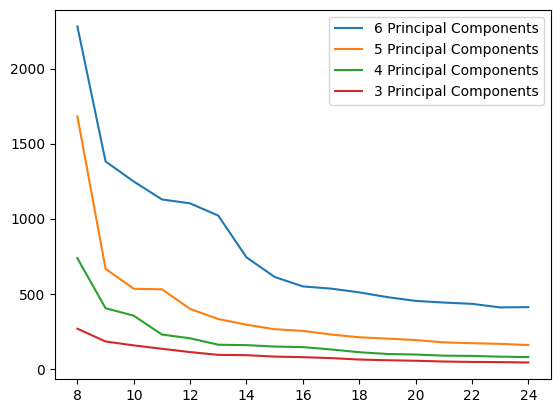

In [ ]:
for pc in poss_principal_components[::-1]:
    inertia_col = f'{pc}_inertia'
    plt.plot(kmeans_eval_grid.index, kmeans_eval_grid.loc[:, inertia_col], label=f'{pc} Principal Components')

plt.legend()

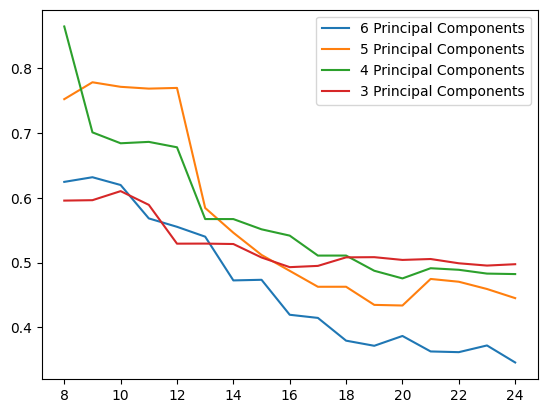

In [ ]:
for pc in poss_principal_components[::-1]:
    silhouette_score_col = f'{pc}_silhouette_score'
    plt.plot(kmeans_eval_grid.index, kmeans_eval_grid.loc[:, silhouette_score_col], label=f'{pc} Principal Components')

plt.legend()

Knowing that there are 16 genres currently in the dataset, we can use that as a reasonable cutoff for `inertia` and `silhouette` performance. By the 16th cluster, it seems that 3 principal components has both the best (lowest) `inertia` and best (highest) `silhouette` score when compared to all other k-means models. 

~~More promising, is that the same model (built on the 3-Principal Component dataset) has the best performance across all cluster sizes for the `inertia` metric, and for all cluster sizes greater than 14 components for the `silhouette` metric. Could this indicate that the current clustering model could perform well~~

### Genre balance

Checking the balance of the genre classes

[ 45.  67.  77.  83.  88.  93.  96.  98.  99. 100. 100. 100. 100. 100.
 100. 100.]


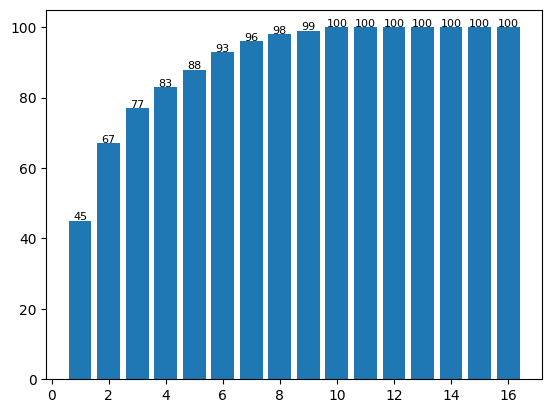

In [ ]:
genre_balance = validation_df.loc[:, ['song_id', 'genre_id']].drop_duplicates().copy()
genre_balance = genre_balance.loc[:, ['genre_id']].value_counts()
genre_balance = np.round(100 * genre_balance / NUM_SONGS, 0)
cum_genre_distribution = np.tri(16) @ genre_balance

print(cum_genre_distribution)

plt.bar(range(1,17), cum_genre_distribution)
for i in range(16):
    plt.text(i+1, cum_genre_distribution[i] + .2, f"{cum_genre_distribution[i]:.0f}", fontsize=8, ha='center')

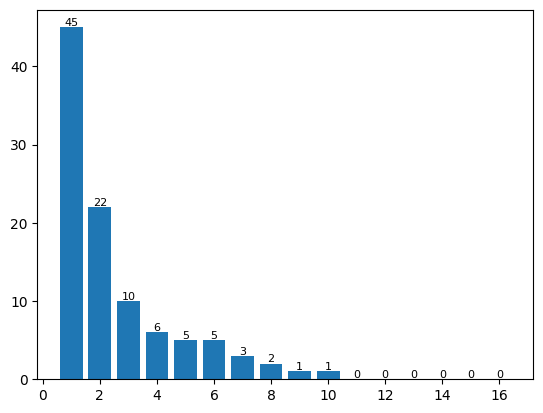

In [ ]:
genre_balance_arr = genre_balance.values
plt.bar(range(1,17), genre_balance_arr)
for i in range(16):
    plt.text(i+1, genre_balance_arr[i]+.2, f"{genre_balance_arr[i]:.0f}", fontsize=8, ha='center')

In [ ]:
validation_df.loc[:, ['song_id', 'genre_id']].drop_duplicates().genre_id

0        1
2        1
3        4
9        1
11       1
        ..
14044    1
14047    2
14050    2
14053    2
14056    1
Name: genre_id, Length: 6436, dtype: int64

In [ ]:
min(kmeans.labels_)

np.int32(0)

In [ ]:
a = validation_df.loc[:, ['song_id', 'genre_id']].drop_duplicates().copy()
pcs = max(kmeans.labels_) + 1
labels_col = f'{pcs}_clusters'
a.loc[:, labels_col] = kmeans.labels_
a.drop('song_id', axis=1, inplace=True)
a_piv = pd.pivot_table(a, values='genre_id', index=[labels_col, 'genre_id'], aggfunc="count")
a_piv.columns = ['count']
# pd.merge(a_piv.reset_index(), pd.DataFrame(kmeans.labels_).value_counts(), "inner", left_on="24_clusters", right_on=
a_piv

count
24_clusters genre_id       
0           1            23
            2             5
            3             5
            4             5
            5             3
...                     ...
23          7             6
            8            13
            12            2
            13            8
            15            3

[220 rows x 1 columns]

In [ ]:
pd.DataFrame(pd.DataFrame(kmeans.labels_).value_counts()).reset_index()

,0,count
0,1,980
1,18,860
2,22,747
3,14,437
4,20,431
5,2,355
6,13,338
7,5,325
8,12,300
9,23,232


This distribution makes it more clear why the performances for the kmeans models with clusters close to 8 have the highest performance when compared to models of highest cluster counts. `DBSCAN` might be the better approach.

### New

In [ ]:
eps_list = np.arange(.25, .875, .125)
min_samples_list = range(1, 10, 2)

model_metrics = [[]] * len(poss_principal_components) * len(eps_list) * len(min_samples_list)
model_metrics_columns = [
    "model",
    "inertia",
    "silhouette_score",
    "homogeneity_score",
    "completeness_score",
]
print(len(model_metrics))
row_index = 0

for n_components in poss_principal_components:
    for eps in eps_list:
        for min_samples in min_samples_list:
            dbscan = DBSCAN(
                eps=np.round(eps, 1), # .3 was returned with a floating point error
                min_samples=min_samples,
                n_jobs=-1
            ).fit(data_scaled)            
            
            # Store the cluster labeling by each model
            model_name = f"dbscan_pca={n_components}_eps={eps}_minsamples={min_samples}"
            song_genre.loc[:, model_name] = dbscan.labels_
            print(model_name)
            
            # Generate 1 metrics row per model
            model_metrics[row_index] = [
                model_name,
                None, # inertia
                silhouette_score(data_pca, dbscan.labels_),
                homogeneity_score(song_genre.genre_id, dbscan.labels_),
                completeness_score(song_genre.genre_id, dbscan.labels_)
            ]
            
            row_index += 1
            # break
        break
    break

song_genre

model_metrics_df = pd.DataFrame(model_metrics)
model_metrics_df.columns = model_metrics_columns
model_metrics_df

100
dbscan_pca=3_eps=0.25_minsamples=1
dbscan_pca=3_eps=0.25_minsamples=3
dbscan_pca=3_eps=0.25_minsamples=5
dbscan_pca=3_eps=0.25_minsamples=7
dbscan_pca=3_eps=0.25_minsamples=9


,model,inertia,silhouette_score,homogeneity_score,completeness_score
0,dbscan_pca=3_eps=0.25_minsamples=1,None,-0.187733,0.765674,0.184514
1,dbscan_pca=3_eps=0.25_minsamples=3,None,-0.614771,0.048185,0.071030
2,dbscan_pca=3_eps=0.25_minsamples=5,None,-0.560820,0.020870,0.049774
3,dbscan_pca=3_eps=0.25_minsamples=7,None,-0.547661,0.014358,0.042012
4,dbscan_pca=3_eps=0.25_minsamples=9,None,-0.423655,0.011844,0.040779
...,...,...,...,...,...
95,NaN,None,NaN,NaN,NaN
96,NaN,None,NaN,NaN,NaN
97,NaN,None,NaN,NaN,NaN
98,NaN,None,NaN,NaN,NaN


In [ ]:
model_metrics_df = pd.DataFrame(model_metrics)
model_metrics_df.columns = model_metrics_columns
model_metrics_df

,model,inertia,silhouette_score,homogeneity_score,completeness_score
0,dbscan_pca=3_eps=0.25_minsamples=1,None,-0.187733,0.765674,0.184514
1,dbscan_pca=3_eps=0.25_minsamples=3,None,-0.614771,0.048185,0.071030
2,dbscan_pca=3_eps=0.25_minsamples=5,None,-0.560820,0.020870,0.049774
3,dbscan_pca=3_eps=0.25_minsamples=7,None,-0.547661,0.014358,0.042012
4,dbscan_pca=3_eps=0.25_minsamples=9,None,-0.423655,0.011844,0.040779
...,...,...,...,...,...
95,NaN,None,NaN,NaN,NaN
96,NaN,None,NaN,NaN,NaN
97,NaN,None,NaN,NaN,NaN
98,NaN,None,NaN,NaN,NaN
